请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [1]:
!pwd
!pip install scikit-image
!pip install pydicom
!pip install paddleseg

/home/aistudio
Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/, https://pypi.tuna.tsinghua.edu.cn/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 884.4 kB/s eta 0:00:000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 2.6 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 kB 106.9 kB/s eta 0:00:00a 0:00:01
  Created wheel for PyWavelets: filename=PyWavelets-1.4.0-cp37-cp37m-linux_x86_64.whl size=5912088 sha256=ebfe75637c5150295017262c4d502dae2ee8d10fd35abcbb15914cc8581aa3cd
  Stored in directory: /home/aistudio/.cache/pip/wheels/ee/e9/77/648cd0740669dfca102c54f51d5bafacfd639faff2717c3c4e
Successfully built PyWavelets

[notice] A new release of pip available: 22.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Looking in i

In [ ]:
! git clone https://gitee.com/paddlepaddle/PaddleSeg.git
%cd ~/PaddleSeg/
! pip install paddleseg

Cloning into 'PaddleSeg'...
remote: Enumerating objects: 25638, done.
remote: Counting objects: 100% (10607/10607), done.
remote: Compressing objects: 100% (4565/4565), done.
remote: Total 25638 (delta 6839), reused 9376 (delta 5873), pack-reused 15031
Receiving objects: 100% (25638/25638), 348.65 MiB | 26.59 MiB/s, done.
Resolving deltas: 100% (16699/16699), done.
Checking connectivity... done.
/home/aistudio/PaddleSeg
Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/, https://pypi.tuna.tsinghua.edu.cn/simple/

[notice] A new release of pip available: 22.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
! mkdir dataset
%cd dataset
!unzip -q -n /home/aistudio/data/data144729/RVSC.zip  -d /home/aistudio/PaddleSeg/dataset

/home/aistudio/PaddleSeg/dataset


In [2]:
import pandas as pd
import os
from tqdm import tqdm
import logging
import numpy as np

from PIL import Image

import cv2
import pydicom
import pydicom
import matplotlib.pyplot as plt
import scipy.misc

In [3]:
import os
import numpy as np
import cv2
import pydicom
import pydicom
import matplotlib.pyplot as plt
import scipy.misc
import random

def mkdir(path):
 
	folder = os.path.exists(path)
 
	if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
		os.makedirs(path)            #makedirs 创建文件时如果路径不存在会创建这个路径
		print("---  OK  ---")
 
	else:
		print ("---  There is this folder!  ---")

def create_datalist(data_path,image_path,label_path):
    data_names = os.listdir(image_path)
    random.shuffle(data_names)  # 打乱数据
    k=0
    with open(os.path.join(data_path, 'train_list.txt'), 'w') as tf:
        with open(os.path.join(data_path, 'val_list.txt'), 'w') as vf:
            for i in data_names:
                patient_img=image_path+'/'+i
                label_img=label_path+'/'+i
                for j in os.listdir(patient_img):
                    # print(patient_img+'/'+j)
                    # print(label_img+'/'+j)
                    if k%9==0:
                        vf.write(patient_img+'/'+j + ' ' + label_img+'/'+j + '\n')
                    else:
                        tf.write(patient_img+'/'+j + ' ' + label_img+'/'+j + '\n')
                    k=k+1


def MakeDataset(train_path,label_path,data_path,label_path_in,label_path_out,model='train'):
    mkdir(label_path_out)
    mkdir(label_path_in)
    mkdir(data_path)
    for i in os.listdir(train_path):
        # print(i)
        patient=i[7:11]
        file=train_path+'/patient'+str(patient)+'/P'+str(patient)+'list.txt'
        # print(file)
        names=[]
        with open(file) as f:
            line = f.readline()
            while line:
                # print(line.split('\\')[3][0:8])
                names.append(line.split('\\')[3][0:8])
                # line_float=[float(line.split()[0]),float(line.split()[1])]
                # array_in.append(line_float)
                line = f.readline()
                line = f.readline()
        for name in names:
            patient=name[1:3]
            idx=name[4:10]
            # print(patient,idx)
            
            path=train_path+'/patient'+str(patient)+'/P'+str(patient)+'dicom/P'+str(patient)+'-'+str(idx)+'.dcm'
            if(model=='train'):
                in_path=label_path+'/patient'+str(patient)+'/P'+str(patient)+'contours-manual/P'+str(patient)+'-'+str(idx)+'-icontour-manual.txt'
                out_path=label_path+'/patient'+str(patient)+'/P'+str(patient)+'contours-manual/P'+str(patient)+'-'+str(idx)+'-ocontour-manual.txt'
            else:
                in_path=label_path+'/P'+str(patient)+'contours-manual/P'+str(patient)+'-'+str(idx)+'-icontour-manual.txt'
                out_path=label_path+'/P'+str(patient)+'contours-manual/P'+str(patient)+'-'+str(idx)+'-ocontour-manual.txt'
            ds = pydicom.read_file(path)  #读取.dcm文件
            img = ds.pixel_array  # 提取图像信息
            
            # plt.axis('off')
            # plt.imshow(img)
            
            # plt.savefig(data_path+'/P'+str(patient)+'-'+str(idx)+'.png',bbox_inches='tight')
            cv2.imwrite(data_path+'/P'+str(patient)+'-'+str(idx)+'.png',img*255)
            # plt.close()
            array_in=[]
            array_out=[]
            with open(in_path) as f:
                line = f.readline()
                while line:
                        line_float=[float(line.split()[0]),float(line.split()[1])]
                        array_in.append(line_float)
                        line = f.readline()
                        
            with open(in_path) as f:
                line = f.readline()
                while line:
                    line_float=[float(line.split()[0]),float(line.split()[1])]
                    array_out.append(line_float)
                    line = f.readline()
            array_in=np.array(array_in)
            array_out=np.array(array_out)
            # print(type(array_in))
            imgName=data_path+'/P'+str(patient)+'-'+str(idx)+'.png'
            # 展示原图
            img_mask = cv2.imread(imgName)
            # plt.imshow(img_mask)
            plt.axis('off')
            # 创建掩膜
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            
            polygon_in = np.array(array_in, np.int32) # 坐标为顺时针方向
            cv2.fillConvexPoly(mask, polygon_in, (255, 255, 255))
            # # 展示掩膜图片
            # plt.imshow(mask)
            cv2.imwrite(label_path_in+'/P'+str(patient)+'-'+str(idx)+'.png',mask)
            img=cv2.imread(label_path_in+'/P'+str(patient)+'-'+str(idx)+'.png')
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            difference = (img_gray.max() - img_gray.min()) // 2
            _, img_binary = cv2.threshold(img_gray, difference, 1, cv2.THRESH_BINARY)
            cv2.imwrite(label_path_in+'/P'+str(patient)+'-'+str(idx)+'.png',img_binary)            
            # plt.savefig(label_path_in+'/P'+str(patient)+'-'+str(idx)+'.png',bbox_inches='tight')
            # plt.close()
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            polygon_out = np.array(array_out, np.int32) # 坐标为顺时针方向
            cv2.fillConvexPoly(mask, polygon_in, (255, 255, 255))

            # plt.axis('off')
            # plt.imshow(mask)
            # plt.savefig(label_path_out+'/P'+str(patient)+'-'+str(idx)+'.png',bbox_inches='tight')
            cv2.imwrite(label_path_out+'/P'+str(patient)+'-'+str(idx)+'.png',mask)
            img=cv2.imread(label_path_out+'/P'+str(patient)+'-'+str(idx)+'.png')
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            difference = (img_gray.max() - img_gray.min()) // 2
            _, img_binary = cv2.threshold(img_gray, difference, 1, cv2.THRESH_BINARY)
            cv2.imwrite(label_path_out+'/P'+str(patient)+'-'+str(idx)+'.png',img_binary)
            # plt.close()

---  OK  ---
---  OK  ---
---  OK  ---
---  OK  ---
---  OK  ---
---  OK  ---
---  OK  ---
---  OK  ---
---  OK  ---


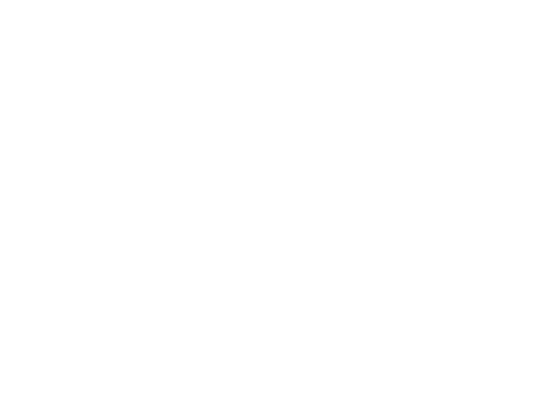

In [ ]:
train_path='/home/aistudio/PaddleSeg/dataset/RVSC/TrainingSet'
label_path='/home/aistudio/PaddleSeg/dataset/RVSC/TrainingSet'
data_path='/home/aistudio/PaddleSeg/dataset/train_img'
label_path_in='/home/aistudio/PaddleSeg/dataset/train_label_img_in'
label_path_out='/home/aistudio/PaddleSeg/dataset/train_label_img_out'
MakeDataset(train_path,label_path,data_path,label_path_in,label_path_out,'train')
train_path='/home/aistudio/PaddleSeg/dataset/RVSC/Test1Set'
label_path='/home/aistudio/PaddleSeg/dataset/RVSC/Test1SetContours/'
data_path='/home/aistudio/PaddleSeg/dataset/test1_img'
label_path_in='/home/aistudio/PaddleSeg/dataset/test1_label_img_in'
label_path_out='/home/aistudio/PaddleSeg/dataset/test1_label_img_out'
MakeDataset(train_path,label_path,data_path,label_path_in,label_path_out,'val')

train_path='/home/aistudio/PaddleSeg/dataset/RVSC/Test2Set'
label_path='/home/aistudio/PaddleSeg/dataset/RVSC/Test2SetContours/'
data_path='/home/aistudio/PaddleSeg/dataset/test2_img'
label_path_in='/home/aistudio/PaddleSeg/dataset/test2_label_img_in'
label_path_out='/home/aistudio/PaddleSeg/dataset/test2_label_img_out'
MakeDataset(train_path,label_path,data_path,label_path_in,label_path_out,'val')

In [4]:
%cd /home/aistudio/PaddleSeg/dataset/
import random
!pwd
data_path=''
image_path='train_img'
label_path='train_label_img_in'
# create_datalist(data_path,image_path,label_path)
data_names = os.listdir(image_path)
random.shuffle(data_names)  # 打乱数据
k=0
with open(os.path.join(data_path, 'train_list.txt'), 'w') as tf:
    with open(os.path.join(data_path, 'val_list.txt'), 'w') as vf:
        for i in data_names:
            # print(i)
            patient_img=image_path+'/'+i
            label_img=label_path+'/'+i
            
            if k%9==0:
                vf.write(patient_img+ ' ' + label_img+ '\n')
            else:
                tf.write(patient_img + ' ' + label_img + '\n')
            k=k+1
data_path=''
image_path='test1_img'
label_path='test1_label_img_in'
data_names = os.listdir(image_path)
random.shuffle(data_names)  # 打乱数据
with open(os.path.join(data_path, 'test1_list.txt'), 'w') as tf:
    for i in data_names:
        patient_img=image_path+'/'+i
        label_img=label_path+'/'+i
        tf.write(patient_img +'\n')

data_path=''
image_path='test2_img'
label_path='test2_label_img_in'
data_names = os.listdir(image_path)
random.shuffle(data_names)  # 打乱数据
with open(os.path.join(data_path, 'test2_list.txt'), 'w') as tf:
    for i in data_names:
        patient_img=image_path+'/'+i
        label_img=label_path+'/'+i
        tf.write(patient_img+'\n')

/home/aistudio/PaddleSeg/dataset
/home/aistudio/PaddleSeg/dataset


In [5]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F

from paddleseg.cvlibs import manager


@manager.LOSSES.add_component
class BCELoss(nn.Layer):

    def __init__(self,
                 weight=None,
                 pos_weight=None,
                 ignore_index=255,
                 edge_label=False):
        super().__init__()
        self.weight = weight
        self.pos_weight = pos_weight
        self.ignore_index = ignore_index
        self.edge_label = edge_label
        self.EPS = 1e-10

        if self.weight is not None:
            if isinstance(self.weight, str):
                if self.weight != 'dynamic':
                    raise ValueError(
                        "if type of `weight` is str, it should equal to 'dynamic', but it is {}"
                        .format(self.weight))
            elif not isinstance(self.weight, paddle.Tensor):
                raise TypeError(
                    'The type of `weight` is wrong, it should be Tensor or str, but it is {}'
                    .format(type(self.weight)))

    def forward(self, logit, label):
        if len(label.shape) != len(logit.shape):
            label = paddle.unsqueeze(label, 1)
        mask = (label != self.ignore_index)
        mask = paddle.cast(mask, 'float32')
        # label.shape should equal to the logit.shape
        if label.shape[1] != logit.shape[1]:
            label = label.squeeze(1)
            label = F.one_hot(label, logit.shape[1])
            label = label.transpose((0, 3, 1, 2))
        if isinstance(self.weight, str):
            pos_index = (label == 1)
            neg_index = (label == 0)
            pos_num = paddle.sum(pos_index.astype('float32'))
            neg_num = paddle.sum(neg_index.astype('float32'))
            sum_num = pos_num + neg_num
            weight_pos = 2 * neg_num / (sum_num + self.EPS)
            weight_neg = 2 * pos_num / (sum_num + self.EPS)
            weight = weight_pos * label + weight_neg * (1 - label)
        else:
            weight = self.weight
        if isinstance(self.pos_weight, str):
            pos_index = (label == 1)
            neg_index = (label == 0)
            pos_num = paddle.sum(pos_index.astype('float32'))
            neg_num = paddle.sum(neg_index.astype('float32'))
            sum_num = pos_num + neg_num
            pos_weight = 2 * neg_num / (sum_num + self.EPS)
        else:
            pos_weight = self.pos_weight
        label = label.astype('float32')
        loss = paddle.nn.functional.binary_cross_entropy_with_logits(
            logit,
            label,
            weight=weight,
            reduction='none',
            pos_weight=pos_weight)
        loss = loss * mask
        loss = paddle.mean(loss) / (paddle.mean(mask) + self.EPS)
        label.stop_gradient = True
        mask.stop_gradient = True

        return loss

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddleseg/cvlibs/manager.py:114: UserWarning: BCELoss exists already! It is now updated to <class '__main__.BCELoss'> !!!
  format(component_name, component))


In [6]:
%cd /home/aistudio/PaddleSeg/
# 参数调整
import paddle
from paddleseg.models import UNet, UNetPlusPlus
# from unet import UNet_3Plus
import paddleseg.transforms as T
from paddleseg.datasets import Dataset
# from paddleseg.models.losses import DiceLoss

# from paddleseg.models.losses import CrossEntropyLoss,FocalLoss,LovaszSoftmaxLoss
# 构建训练集
train_transforms = [
    T.RandomHorizontalFlip(),  # 水平翻转
    T.RandomVerticalFlip(),  # 垂直翻转
    T.RandomRotation(),  # 随机旋转
    T.RandomScaleAspect(),  # 随机缩放
    T.RandomDistort(),  # 随机扭曲
    T.Resize(target_size=(256, 256)),  # 这里为了加快速度，改为256x256
    T.Normalize()  # 归一化
]
train_dataset = Dataset(
    transforms=train_transforms,
    dataset_root='dataset',
    num_classes=2,
    mode='train',
    train_path='dataset/train_list.txt',
    separator=' ',
)
# 构建验证集
val_transforms = [
    T.Resize(target_size=(256, 256)),
    T.Normalize()
]
val_dataset = Dataset(
    transforms=val_transforms,
    dataset_root='dataset',
    num_classes=2,
    mode='val',
    val_path='dataset/val_list.txt',
    separator=' ',
)
# 优化器及损失
epochs = 5
batch_size = 16
# iters = epochs * 7278 // batch_size //2
iters=200
base_lr = 2e-3
losses = {}
# losses['types'] = [LovaszSoftmaxLoss()]
# losses['coef'] = [1]
losses['types'] = [BCELoss()] 
losses['coef'] = [1]


/home/aistudio/PaddleSeg


In [9]:
# 重写train函数
import os
import time
from collections import deque
import shutil

import paddle
import paddle.nn.functional as F

from paddleseg.utils import (TimeAverager, calculate_eta, resume, logger,
                             worker_init_fn, train_profiler, op_flops_funs)
from paddleseg.core.val import evaluate


def check_logits_losses(logits_list, losses):
    len_logits = len(logits_list)
    len_losses = len(losses['types'])
    if len_logits != len_losses:
        raise RuntimeError(
            'The length of logits_list should equal to the types of loss config: {} != {}.'
            .format(len_logits, len_losses))


# def loss_computation(logits, labels, losses, edges=None):
#    
#     loss_i = losses['types'][0]
#     coef_i = losses['coef'][0]

#     
#     if loss_i.__class__.__name__ == 'MixedLoss':
#         mixed_loss_list = loss_i(logits, labels)
#         
#         loss_list = [coef_i * mixed_loss for mixed_loss in mixed_loss_list]
#     elif loss_i.__class__.__name__ in ("KLLoss", ):
#         
#         loss_list = [coef_i * loss_i(logits_list[0], logits_list[1].detach())]
#     else:
#         
#         loss_list = [coef_i * loss_i(logits, labels)]

#     
#     return 

def loss_computation(logits_list, labels, losses, edges=None):
    check_logits_losses(logits_list, losses)
    loss_list = []
    for i in range(len(logits_list)):
        logits = logits_list[i]
        loss_i = losses['types'][i]
        coef_i = losses['coef'][i]

        if loss_i.__class__.__name__ == 'MixedLoss':
            mixed_loss_list = loss_i(logits, labels)
            for mixed_loss in mixed_loss_list:
                loss_list.append(coef_i * mixed_loss)
        elif loss_i.__class__.__name__ in ("KLLoss", ):
            loss_list.append(coef_i *
                             loss_i(logits_list[0], logits_list[1].detach()))
        else:
            loss_list.append(coef_i * loss_i(logits, labels))
    return loss_list


# 新增了一个参数 filename 就是保存的npy文件位置 位置就是save_dir+filename
def train(model,
          train_dataset,
          filename,
          val_dataset=None,
          optimizer=None,
          save_dir='output',
          iters=10000,
          batch_size=2,
          resume_model=None,
          save_interval=1000,
          log_iters=10,
          num_workers=0,
          use_vdl=False,
          losses=None,
          keep_checkpoint_max=5,
          test_config=None,
          precision='fp32',
          amp_level='O1',
          profiler_options=None,
          to_static_training=False):
    filename=save_dir+'/'+filename
    print(filename)
    model.train()
    nranks = paddle.distributed.ParallelEnv().nranks
    local_rank = paddle.distributed.ParallelEnv().local_rank

    start_iter = 0
    if resume_model is not None:
        start_iter = resume(model, optimizer, resume_model)

    if not os.path.isdir(save_dir):
        if os.path.exists(save_dir):
            os.remove(save_dir)
        os.makedirs(save_dir)

    # use amp
    if precision == 'fp16':
        logger.info('use AMP to train. AMP level = {}'.format(amp_level))
        scaler = paddle.amp.GradScaler(init_loss_scaling=1024)
        if amp_level == 'O2':
            model, optimizer = paddle.amp.decorate(
                models=model,
                optimizers=optimizer,
                level='O2',
                save_dtype='float32')

    if nranks > 1:
        paddle.distributed.fleet.init(is_collective=True)
        optimizer = paddle.distributed.fleet.distributed_optimizer(
            optimizer)  # The return is Fleet object
        ddp_model = paddle.distributed.fleet.distributed_model(model)

    batch_sampler = paddle.io.DistributedBatchSampler(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    loader = paddle.io.DataLoader(
        train_dataset,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        return_list=True,
        worker_init_fn=worker_init_fn, )

    if use_vdl:
        from visualdl import LogWriter
        log_writer = LogWriter(save_dir)

    if to_static_training:
        model = paddle.jit.to_static(model)
        logger.info("Successfully to apply @to_static")

    avg_loss = 0.0
    avg_loss_list = []
    iters_per_epoch = len(batch_sampler)
    best_mean_iou = -1.0
    best_model_iter = -1
    reader_cost_averager = TimeAverager()
    batch_cost_averager = TimeAverager()
    save_models = deque()
    batch_start = time.time()

    iter = start_iter
    loss_save_list=[]
    while iter < iters:
        for data in loader:
            iter += 1
            if iter > iters:
                version = paddle.__version__
                if version == '2.1.2':
                    continue
                else:
                    break
            reader_cost_averager.record(time.time() - batch_start)
            images = data['img']
            labels = data['label'].astype('int64')
            # print(labels.shape)
            edges = None
            if len(data) == 3:
                edges = data[2].astype('int64')
            if hasattr(model, 'data_format') and model.data_format == 'NHWC':
                images = images.transpose((0, 2, 3, 1))

            
            logits_list = ddp_model(images) if nranks > 1 else model(images)
            loss_list = loss_computation(
                logits_list=logits_list,
                labels=labels,
                losses=losses,
                edges=edges)
            loss = sum(loss_list)
            # 这一步保存loss
            loss_save_list.append(loss)
            loss.backward()
            # if the optimizer is ReduceOnPlateau, the loss is the one which has been pass into step.
            if isinstance(optimizer, paddle.optimizer.lr.ReduceOnPlateau):
                optimizer.step(loss)
            else:
                optimizer.step()

            lr = optimizer.get_lr()

            # update lr
            if isinstance(optimizer, paddle.distributed.fleet.Fleet):
                lr_sche = optimizer.user_defined_optimizer._learning_rate
            else:
                lr_sche = optimizer._learning_rate
            if isinstance(lr_sche, paddle.optimizer.lr.LRScheduler):
                lr_sche.step()

            train_profiler.add_profiler_step(profiler_options)

            model.clear_gradients()
            avg_loss += loss.numpy()[0]
            
            if not avg_loss_list:
                avg_loss_list = [l.numpy() for l in loss_list]
            else:
                for i in range(len(loss_list)):
                    avg_loss_list[i] += loss_list[i].numpy()
            batch_cost_averager.record(
                time.time() - batch_start, num_samples=batch_size)

            if (iter) % log_iters == 0 and local_rank == 0:
                avg_loss /= log_iters
                avg_loss_list = [l[0] / log_iters for l in avg_loss_list]
                remain_iters = iters - iter
                avg_train_batch_cost = batch_cost_averager.get_average()
                avg_train_reader_cost = reader_cost_averager.get_average()
                eta = calculate_eta(remain_iters, avg_train_batch_cost)
                logger.info(
                    "[TRAIN] epoch: {}, iter: {}/{}, loss: {:.4f}, lr: {:.6f}, batch_cost: {:.4f}, reader_cost: {:.5f}, ips: {:.4f} samples/sec | ETA {}"
                    .format((iter - 1
                             ) // iters_per_epoch + 1, iter, iters, avg_loss,
                            lr, avg_train_batch_cost, avg_train_reader_cost,
                            batch_cost_averager.get_ips_average(), eta))
                if use_vdl:
                    log_writer.add_scalar('Train/loss', avg_loss, iter)
                    # Record all losses if there are more than 2 losses.
                    if len(avg_loss_list) > 1:
                        avg_loss_dict = {}
                        for i, value in enumerate(avg_loss_list):
                            avg_loss_dict['loss_' + str(i)] = value
                        for key, value in avg_loss_dict.items():
                            log_tag = 'Train/' + key
                            log_writer.add_scalar(log_tag, value, iter)

                    log_writer.add_scalar('Train/lr', lr, iter)
                    log_writer.add_scalar('Train/batch_cost',
                                          avg_train_batch_cost, iter)
                    log_writer.add_scalar('Train/reader_cost',
                                          avg_train_reader_cost, iter)
                avg_loss = 0.0
                avg_loss_list = []
                reader_cost_averager.reset()
                batch_cost_averager.reset()

            if (iter % save_interval == 0 or
                    iter == iters) and (val_dataset is not None):
                num_workers = 1 if num_workers > 0 else 0

                if test_config is None:
                    test_config = {}

                mean_iou, acc, _, _, _ = evaluate(
                    model,
                    val_dataset,
                    num_workers=num_workers,
                    precision=precision,
                    amp_level=amp_level,
                    **test_config)

                model.train()

            if (iter % save_interval == 0 or iter == iters) and local_rank == 0:
                current_save_dir = os.path.join(save_dir,
                                                "iter_{}".format(iter))
                if not os.path.isdir(current_save_dir):
                    os.makedirs(current_save_dir)
                paddle.save(model.state_dict(),
                            os.path.join(current_save_dir, 'model.pdparams'))
                paddle.save(optimizer.state_dict(),
                            os.path.join(current_save_dir, 'model.pdopt'))
                save_models.append(current_save_dir)
                if len(save_models) > keep_checkpoint_max > 0:
                    model_to_remove = save_models.popleft()
                    shutil.rmtree(model_to_remove)

                if val_dataset is not None:
                    if mean_iou > best_mean_iou:
                        best_mean_iou = mean_iou
                        best_model_iter = iter
                        best_model_dir = os.path.join(save_dir, "best_model")
                        paddle.save(
                            model.state_dict(),
                            os.path.join(best_model_dir, 'model.pdparams'))
                    logger.info(
                        '[EVAL] The model with the best validation mIoU ({:.4f}) was saved at iter {}.'
                        .format(best_mean_iou, best_model_iter))

                    if use_vdl:
                        log_writer.add_scalar('Evaluate/mIoU', mean_iou, iter)
                        log_writer.add_scalar('Evaluate/Acc', acc, iter)
            batch_start = time.time()

    # Calculate flops.
    if local_rank == 0 and not (precision == 'fp16' and amp_level == 'O2'):
        _, c, h, w = images.shape
        _ = paddle.flops(
            model, [1, c, h, w],
            custom_ops={paddle.nn.SyncBatchNorm: op_flops_funs.count_syncbn})

    # Sleep for half a second to let dataloader release resources.
    time.sleep(0.5)
    if use_vdl:
        log_writer.close()
    
    np.save(filename, loss_save_list)

# **uent及其变种**

In [10]:
unet_model = UNet(num_classes=2)


W1224 01:07:12.980618    98 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 10.1
W1224 01:07:12.986021    98 device_context.cc:465] device: 0, cuDNN Version: 7.6.


In [11]:
!export CUDA_VISIBLE_DEVICES=0 # 设置1张可用的卡
print(type(unet_model))
# paddle.summary(unet_model, (1, 3, 128, 128))  # 查看网络结构
lr = paddle.optimizer.lr.CosineAnnealingDecay(base_lr, T_max=(iters // 3), last_epoch=0.5)
unt_optimizer = paddle.optimizer.Adam(lr, parameters=unet_model.parameters(),weight_decay=4.0e-5)
# 训练
os.environ['FLAGS_eager_delete_tensor_gb'] = "0.0"
# 更改对应文件名即可
train(
    model=unet_model,
    filename='unet.npy',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=unt_optimizer,
    save_dir='output_unet',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/5),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True)

<class 'paddleseg.models.unet.UNet'>
output_unet/unet.npy


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


2023-12-24 01:07:21 [INFO]	[TRAIN] epoch: 1, iter: 10/200, loss: 0.2971, lr: 0.001878, batch_cost: 0.3253, reader_cost: 0.11276, ips: 49.1800 samples/sec | ETA 00:01:01
2023-12-24 01:07:24 [INFO]	[TRAIN] epoch: 2, iter: 20/200, loss: 0.2080, lr: 0.001561, batch_cost: 0.3275, reader_cost: 0.11830, ips: 48.8475 samples/sec | ETA 00:00:58
2023-12-24 01:07:28 [INFO]	[TRAIN] epoch: 3, iter: 30/200, loss: 0.1887, lr: 0.001119, batch_cost: 0.3264, reader_cost: 0.11615, ips: 49.0171 samples/sec | ETA 00:00:55
2023-12-24 01:07:31 [INFO]	[TRAIN] epoch: 4, iter: 40/200, loss: 0.1822, lr: 0.000651, batch_cost: 0.3275, reader_cost: 0.11732, ips: 48.8552 samples/sec | ETA 00:00:52
2023-12-24 01:07:31 [INFO]	Start evaluating (total_samples: 27, total_iters: 27)...


27/27 [==============================] - 0s 16ms/step - batch_cost: 0.0158 - reader cost: 4.1474e-0


2023-12-24 01:07:31 [INFO]	[EVAL] #Images: 27 mIoU: 0.4984 Acc: 0.9363 Kappa: 0.0966 Dice: 0.5408
2023-12-24 01:07:31 [INFO]	[EVAL] Class IoU: 
[0.9361 0.0608]
2023-12-24 01:07:31 [INFO]	[EVAL] Class Precision: 
[0.9435 0.3435]
2023-12-24 01:07:31 [INFO]	[EVAL] Class Recall: 
[0.9916 0.0688]
2023-12-24 01:07:34 [INFO]	[EVAL] The model with the best validation mIoU (0.4984) was saved at iter 40.
2023-12-24 01:07:37 [INFO]	[TRAIN] epoch: 4, iter: 50/200, loss: 0.1905, lr: 0.000260, batch_cost: 0.2711, reader_cost: 0.05854, ips: 59.0108 samples/sec | ETA 00:00:40
2023-12-24 01:07:40 [INFO]	[TRAIN] epoch: 5, iter: 60/200, loss: 0.1772, lr: 0.000034, batch_cost: 0.3229, reader_cost: 0.11299, ips: 49.5443 samples/sec | ETA 00:00:45
2023-12-24 01:07:44 [INFO]	[TRAIN] epoch: 6, iter: 70/200, loss: 0.1812, lr: 0.000023, batch_cost: 0.3219, reader_cost: 0.11193, ips: 49.7046 samples/sec | ETA 00:00:41
2023-12-24 01:07:47 [INFO]	[TRAIN] epoch: 7, iter: 80/200, loss: 0.1672, lr: 0.000229, batch_co

27/27 [==============================] - 0s 15ms/step - batch_cost: 0.0150 - reader cost: 4.4147e-


2023-12-24 01:07:47 [INFO]	[EVAL] #Images: 27 mIoU: 0.5696 Acc: 0.9294 Kappa: 0.3117 Dice: 0.6556
2023-12-24 01:07:47 [INFO]	[EVAL] Class IoU: 
[0.9281 0.2111]
2023-12-24 01:07:47 [INFO]	[EVAL] Class Precision: 
[0.9569 0.3901]
2023-12-24 01:07:47 [INFO]	[EVAL] Class Recall: 
[0.9686 0.315 ]
2023-12-24 01:07:50 [INFO]	[EVAL] The model with the best validation mIoU (0.5696) was saved at iter 80.
2023-12-24 01:07:53 [INFO]	[TRAIN] epoch: 7, iter: 90/200, loss: 0.1751, lr: 0.000606, batch_cost: 0.2683, reader_cost: 0.05818, ips: 59.6364 samples/sec | ETA 00:00:29
2023-12-24 01:07:56 [INFO]	[TRAIN] epoch: 8, iter: 100/200, loss: 0.1595, lr: 0.001071, batch_cost: 0.3233, reader_cost: 0.11206, ips: 49.4897 samples/sec | ETA 00:00:32
2023-12-24 01:08:00 [INFO]	[TRAIN] epoch: 9, iter: 110/200, loss: 0.1736, lr: 0.001521, batch_cost: 0.3222, reader_cost: 0.11186, ips: 49.6580 samples/sec | ETA 00:00:28
2023-12-24 01:08:03 [INFO]	[TRAIN] epoch: 10, iter: 120/200, loss: 0.1703, lr: 0.001854, batc

27/27 [==============================] - 0s 15ms/step - batch_cost: 0.0141 - reader cost: 4.0651e-04


2023-12-24 01:08:03 [INFO]	[EVAL] #Images: 27 mIoU: 0.6318 Acc: 0.9200 Kappa: 0.4753 Dice: 0.7359
2023-12-24 01:08:03 [INFO]	[EVAL] Class IoU: 
[0.9165 0.3471]
2023-12-24 01:08:03 [INFO]	[EVAL] Class Precision: 
[0.9805 0.4046]
2023-12-24 01:08:03 [INFO]	[EVAL] Class Recall: 
[0.9334 0.7095]
2023-12-24 01:08:06 [INFO]	[EVAL] The model with the best validation mIoU (0.6318) was saved at iter 120.
2023-12-24 01:08:09 [INFO]	[TRAIN] epoch: 10, iter: 130/200, loss: 0.1501, lr: 0.001998, batch_cost: 0.2695, reader_cost: 0.05877, ips: 59.3661 samples/sec | ETA 00:00:18
2023-12-24 01:08:12 [INFO]	[TRAIN] epoch: 11, iter: 140/200, loss: 0.1698, lr: 0.001920, batch_cost: 0.3275, reader_cost: 0.11656, ips: 48.8517 samples/sec | ETA 00:00:19
2023-12-24 01:08:15 [INFO]	[TRAIN] epoch: 12, iter: 150/200, loss: 0.1483, lr: 0.001637, batch_cost: 0.3213, reader_cost: 0.11028, ips: 49.7933 samples/sec | ETA 00:00:16
2023-12-24 01:08:19 [INFO]	[TRAIN] epoch: 13, iter: 160/200, loss: 0.1636, lr: 0.001213,

27/27 [==============================] - 0s 15ms/step - batch_cost: 0.0148 - reader cost: 4.3616e-


2023-12-24 01:08:19 [INFO]	[EVAL] #Images: 27 mIoU: 0.5463 Acc: 0.9419 Kappa: 0.2409 Dice: 0.6162
2023-12-24 01:08:19 [INFO]	[EVAL] Class IoU: 
[0.9413 0.1512]
2023-12-24 01:08:19 [INFO]	[EVAL] Class Precision: 
[0.9495 0.5494]
2023-12-24 01:08:19 [INFO]	[EVAL] Class Recall: 
[0.991  0.1726]
2023-12-24 01:08:20 [INFO]	[EVAL] The model with the best validation mIoU (0.6318) was saved at iter 120.
2023-12-24 01:08:23 [INFO]	[TRAIN] epoch: 14, iter: 170/200, loss: 0.1398, lr: 0.000741, batch_cost: 0.2736, reader_cost: 0.06259, ips: 58.4883 samples/sec | ETA 00:00:08
2023-12-24 01:08:26 [INFO]	[TRAIN] epoch: 14, iter: 180/200, loss: 0.1464, lr: 0.000327, batch_cost: 0.3188, reader_cost: 0.10823, ips: 50.1900 samples/sec | ETA 00:00:06
2023-12-24 01:08:30 [INFO]	[TRAIN] epoch: 15, iter: 190/200, loss: 0.1366, lr: 0.000063, batch_cost: 0.3279, reader_cost: 0.11683, ips: 48.8023 samples/sec | ETA 00:00:03
2023-12-24 01:08:33 [INFO]	[TRAIN] epoch: 16, iter: 200/200, loss: 0.1372, lr: 0.000007,

27/27 [==============================] - 0s 15ms/step - batch_cost: 0.0144 - reader cost: 4.2379e-


2023-12-24 01:08:33 [INFO]	[EVAL] #Images: 27 mIoU: 0.6491 Acc: 0.9349 Kappa: 0.5014 Dice: 0.7503
2023-12-24 01:08:33 [INFO]	[EVAL] Class IoU: 
[0.9324 0.3657]
2023-12-24 01:08:33 [INFO]	[EVAL] Class Precision: 
[0.9757 0.4678]
2023-12-24 01:08:33 [INFO]	[EVAL] Class Recall: 
[0.9546 0.6264]
2023-12-24 01:08:36 [INFO]	[EVAL] The model with the best validation mIoU (0.6491) was saved at iter 200.
<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.nn.layer.norm.BatchNorm2D'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
Total Flops: 31075991552     Total Params: 13404354


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


# **AttentionUnet**

In [12]:
from paddleseg.models import AttentionUNet

# 创建attention_unet模型
attentionunet_model = AttentionUNet(num_classes=2)

# 其余的训练设置保持不变...

# 为attention_unet创建优化器
attention_optimizer = paddle.optimizer.AdamW(
    learning_rate=1e-3,
    parameters=attentionunet_model.parameters(),
    weight_decay=4.0e-5
)

# 训练attention_unet
train(
    model=attentionunet_model,
    filename='attentionunet.npy',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=attention_optimizer,
    save_dir='output_attentionunet',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/5),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True
)

output_attentionunet/attentionunet.npy
2023-12-24 01:09:08 [INFO]	[TRAIN] epoch: 1, iter: 10/200, loss: 0.5212, lr: 0.001000, batch_cost: 0.4877, reader_cost: 0.08171, ips: 32.8095 samples/sec | ETA 00:01:32
2023-12-24 01:09:13 [INFO]	[TRAIN] epoch: 2, iter: 20/200, loss: 0.3250, lr: 0.001000, batch_cost: 0.5043, reader_cost: 0.10124, ips: 31.7255 samples/sec | ETA 00:01:30
2023-12-24 01:09:18 [INFO]	[TRAIN] epoch: 3, iter: 30/200, loss: 0.2828, lr: 0.001000, batch_cost: 0.5094, reader_cost: 0.10506, ips: 31.4081 samples/sec | ETA 00:01:26
2023-12-24 01:09:23 [INFO]	[TRAIN] epoch: 4, iter: 40/200, loss: 0.2495, lr: 0.001000, batch_cost: 0.5030, reader_cost: 0.09981, ips: 31.8119 samples/sec | ETA 00:01:20
2023-12-24 01:09:23 [INFO]	Start evaluating (total_samples: 27, total_iters: 27)...


27/27 [==============================] - 1s 22ms/step - batch_cost: 0.0217 - reader cost: 4.2207e-


2023-12-24 01:09:24 [INFO]	[EVAL] #Images: 27 mIoU: 0.5404 Acc: 0.9444 Kappa: 0.2238 Dice: 0.6059
2023-12-24 01:09:24 [INFO]	[EVAL] Class IoU: 
[0.9439 0.1368]
2023-12-24 01:09:24 [INFO]	[EVAL] Class Precision: 
[0.9482 0.6629]
2023-12-24 01:09:24 [INFO]	[EVAL] Class Recall: 
[0.9952 0.1471]
2023-12-24 01:09:31 [INFO]	[EVAL] The model with the best validation mIoU (0.5404) was saved at iter 40.
2023-12-24 01:09:35 [INFO]	[TRAIN] epoch: 4, iter: 50/200, loss: 0.2391, lr: 0.001000, batch_cost: 0.4511, reader_cost: 0.04720, ips: 35.4721 samples/sec | ETA 00:01:07
2023-12-24 01:09:40 [INFO]	[TRAIN] epoch: 5, iter: 60/200, loss: 0.2194, lr: 0.001000, batch_cost: 0.5066, reader_cost: 0.10278, ips: 31.5836 samples/sec | ETA 00:01:10
2023-12-24 01:09:45 [INFO]	[TRAIN] epoch: 6, iter: 70/200, loss: 0.2210, lr: 0.001000, batch_cost: 0.5067, reader_cost: 0.10185, ips: 31.5747 samples/sec | ETA 00:01:05
2023-12-24 01:09:50 [INFO]	[TRAIN] epoch: 7, iter: 80/200, loss: 0.2037, lr: 0.001000, batch_co

27/27 [==============================] - 1s 22ms/step - batch_cost: 0.0218 - reader cost: 4.7531e-


2023-12-24 01:09:51 [INFO]	[EVAL] #Images: 27 mIoU: 0.4705 Acc: 0.9400 Kappa: 0.0017 Dice: 0.4856
2023-12-24 01:09:51 [INFO]	[EVAL] Class IoU: 
[0.94   0.0011]
2023-12-24 01:09:51 [INFO]	[EVAL] Class Precision: 
[0.9401 0.2874]
2023-12-24 01:09:51 [INFO]	[EVAL] Class Recall: 
[0.9998 0.0011]
2023-12-24 01:09:56 [INFO]	[EVAL] The model with the best validation mIoU (0.5404) was saved at iter 40.
2023-12-24 01:10:01 [INFO]	[TRAIN] epoch: 7, iter: 90/200, loss: 0.2068, lr: 0.001000, batch_cost: 0.4548, reader_cost: 0.05148, ips: 35.1840 samples/sec | ETA 00:00:50
2023-12-24 01:10:06 [INFO]	[TRAIN] epoch: 8, iter: 100/200, loss: 0.1897, lr: 0.001000, batch_cost: 0.5043, reader_cost: 0.10149, ips: 31.7296 samples/sec | ETA 00:00:50
2023-12-24 01:10:11 [INFO]	[TRAIN] epoch: 9, iter: 110/200, loss: 0.1989, lr: 0.001000, batch_cost: 0.5057, reader_cost: 0.10113, ips: 31.6372 samples/sec | ETA 00:00:45
2023-12-24 01:10:16 [INFO]	[TRAIN] epoch: 10, iter: 120/200, loss: 0.2050, lr: 0.001000, batc

27/27 [==============================] - 1s 23ms/step - batch_cost: 0.0224 - reader cost: 4.3256e-0


2023-12-24 01:10:16 [INFO]	[EVAL] #Images: 27 mIoU: 0.4727 Acc: 0.9360 Kappa: 0.0091 Dice: 0.4928
2023-12-24 01:10:16 [INFO]	[EVAL] Class IoU: 
[0.936  0.0094]
2023-12-24 01:10:16 [INFO]	[EVAL] Class Precision: 
[0.9404 0.1161]
2023-12-24 01:10:16 [INFO]	[EVAL] Class Recall: 
[0.9951 0.0102]
2023-12-24 01:10:20 [INFO]	[EVAL] The model with the best validation mIoU (0.5404) was saved at iter 40.
2023-12-24 01:10:25 [INFO]	[TRAIN] epoch: 10, iter: 130/200, loss: 0.1790, lr: 0.001000, batch_cost: 0.4525, reader_cost: 0.04654, ips: 35.3613 samples/sec | ETA 00:00:31
2023-12-24 01:10:30 [INFO]	[TRAIN] epoch: 11, iter: 140/200, loss: 0.1843, lr: 0.001000, batch_cost: 0.5022, reader_cost: 0.09885, ips: 31.8578 samples/sec | ETA 00:00:30
2023-12-24 01:10:35 [INFO]	[TRAIN] epoch: 12, iter: 150/200, loss: 0.1730, lr: 0.001000, batch_cost: 0.5063, reader_cost: 0.10277, ips: 31.5994 samples/sec | ETA 00:00:25
2023-12-24 01:10:40 [INFO]	[TRAIN] epoch: 13, iter: 160/200, loss: 0.1850, lr: 0.001000, 

27/27 [==============================] - 1s 23ms/step - batch_cost: 0.0222 - reader cost: 4.0776e-


2023-12-24 01:10:40 [INFO]	[EVAL] #Images: 27 mIoU: 0.4938 Acc: 0.9352 Kappa: 0.0815 Dice: 0.5332
2023-12-24 01:10:40 [INFO]	[EVAL] Class IoU: 
[0.9349 0.0527]
2023-12-24 01:10:40 [INFO]	[EVAL] Class Precision: 
[0.943  0.2972]
2023-12-24 01:10:40 [INFO]	[EVAL] Class Recall: 
[0.9909 0.0601]
2023-12-24 01:10:44 [INFO]	[EVAL] The model with the best validation mIoU (0.5404) was saved at iter 40.
2023-12-24 01:10:48 [INFO]	[TRAIN] epoch: 14, iter: 170/200, loss: 0.1687, lr: 0.001000, batch_cost: 0.4576, reader_cost: 0.05218, ips: 34.9679 samples/sec | ETA 00:00:13
2023-12-24 01:10:53 [INFO]	[TRAIN] epoch: 14, iter: 180/200, loss: 0.1645, lr: 0.001000, batch_cost: 0.5028, reader_cost: 0.09900, ips: 31.8236 samples/sec | ETA 00:00:10
2023-12-24 01:10:58 [INFO]	[TRAIN] epoch: 15, iter: 190/200, loss: 0.1674, lr: 0.001000, batch_cost: 0.5078, reader_cost: 0.10374, ips: 31.5095 samples/sec | ETA 00:00:05
2023-12-24 01:11:04 [INFO]	[TRAIN] epoch: 16, iter: 200/200, loss: 0.1590, lr: 0.001000, 

27/27 [==============================] - 1s 21ms/step - batch_cost: 0.0207 - reader cost: 5.3272e-


2023-12-24 01:11:04 [INFO]	[EVAL] #Images: 27 mIoU: 0.5288 Acc: 0.9390 Kappa: 0.1909 Dice: 0.5906
2023-12-24 01:11:04 [INFO]	[EVAL] Class IoU: 
[0.9385 0.1192]
2023-12-24 01:11:04 [INFO]	[EVAL] Class Precision: 
[0.9474 0.4693]
2023-12-24 01:11:04 [INFO]	[EVAL] Class Recall: 
[0.9901 0.1377]
2023-12-24 01:11:08 [INFO]	[EVAL] The model with the best validation mIoU (0.5404) was saved at iter 40.
<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.nn.layer.norm.BatchNorm2D'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
Cannot find suitable count function for <class 'paddle.nn.layer.common.Upsample'>. Treat it as zero FLOPs.
Cannot find suitable count function for <class 'paddle.nn.layer.activation.Sigmoid'>. Treat it as zero FLOPs.
Total Flops: 66572647424     Total Params: 34894262


# **Unet++**

In [13]:
from paddleseg.models import UNet,UNetPlusPlus,UNet3Plus

unetpp_model = UNetPlusPlus(num_classes=2)

# unet++
optimizer = paddle.optimizer.AdamW(
    learning_rate=1e-3,
    parameters=unetpp_model.parameters(),
    weight_decay=4.0e-5
)

train(
    model=unetpp_model,
    filename='unetpp.npy',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    save_dir='output_unet++',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/5),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True
)

output_unet++/unetpp.npy
2023-12-24 01:11:22 [INFO]	[TRAIN] epoch: 1, iter: 10/200, loss: 0.5833, lr: 0.001000, batch_cost: 0.3828, reader_cost: 0.07565, ips: 41.7949 samples/sec | ETA 00:01:12
2023-12-24 01:11:26 [INFO]	[TRAIN] epoch: 2, iter: 20/200, loss: 0.4172, lr: 0.001000, batch_cost: 0.4010, reader_cost: 0.09619, ips: 39.8986 samples/sec | ETA 00:01:12
2023-12-24 01:11:30 [INFO]	[TRAIN] epoch: 3, iter: 30/200, loss: 0.3587, lr: 0.001000, batch_cost: 0.4088, reader_cost: 0.10320, ips: 39.1417 samples/sec | ETA 00:01:09
2023-12-24 01:11:34 [INFO]	[TRAIN] epoch: 4, iter: 40/200, loss: 0.3271, lr: 0.001000, batch_cost: 0.4049, reader_cost: 0.09886, ips: 39.5168 samples/sec | ETA 00:01:04
2023-12-24 01:11:34 [INFO]	Start evaluating (total_samples: 27, total_iters: 27)...


27/27 [==============================] - 1s 25ms/step - batch_cost: 0.0248 - reader cost: 5.1559e-04


2023-12-24 01:11:35 [INFO]	[EVAL] #Images: 27 mIoU: 0.4783 Acc: 0.9385 Kappa: 0.0286 Dice: 0.5019
2023-12-24 01:11:35 [INFO]	[EVAL] Class IoU: 
[0.9384 0.0181]
2023-12-24 01:11:35 [INFO]	[EVAL] Class Precision: 
[0.941 0.296]
2023-12-24 01:11:35 [INFO]	[EVAL] Class Recall: 
[0.9971 0.019 ]
2023-12-24 01:11:36 [INFO]	[EVAL] The model with the best validation mIoU (0.4783) was saved at iter 40.
2023-12-24 01:11:39 [INFO]	[TRAIN] epoch: 4, iter: 50/200, loss: 0.3018, lr: 0.001000, batch_cost: 0.3504, reader_cost: 0.04408, ips: 45.6606 samples/sec | ETA 00:00:52
2023-12-24 01:11:43 [INFO]	[TRAIN] epoch: 5, iter: 60/200, loss: 0.2819, lr: 0.001000, batch_cost: 0.4072, reader_cost: 0.10201, ips: 39.2910 samples/sec | ETA 00:00:57
2023-12-24 01:11:47 [INFO]	[TRAIN] epoch: 6, iter: 70/200, loss: 0.2704, lr: 0.001000, batch_cost: 0.4076, reader_cost: 0.10230, ips: 39.2542 samples/sec | ETA 00:00:52
2023-12-24 01:11:51 [INFO]	[TRAIN] epoch: 7, iter: 80/200, loss: 0.2471, lr: 0.001000, batch_cost

27/27 [==============================] - 1s 24ms/step - batch_cost: 0.0235 - reader cost: 4.0158e-0


2023-12-24 01:11:52 [INFO]	[EVAL] #Images: 27 mIoU: 0.4868 Acc: 0.9372 Kappa: 0.0578 Dice: 0.5191
2023-12-24 01:11:52 [INFO]	[EVAL] Class IoU: 
[0.937  0.0366]
2023-12-24 01:11:52 [INFO]	[EVAL] Class Precision: 
[0.942  0.3114]
2023-12-24 01:11:52 [INFO]	[EVAL] Class Recall: 
[0.9944 0.0398]
2023-12-24 01:11:53 [INFO]	[EVAL] The model with the best validation mIoU (0.4868) was saved at iter 80.
2023-12-24 01:11:56 [INFO]	[TRAIN] epoch: 7, iter: 90/200, loss: 0.2315, lr: 0.001000, batch_cost: 0.3451, reader_cost: 0.03905, ips: 46.3643 samples/sec | ETA 00:00:37
2023-12-24 01:12:00 [INFO]	[TRAIN] epoch: 8, iter: 100/200, loss: 0.2284, lr: 0.001000, batch_cost: 0.4033, reader_cost: 0.09740, ips: 39.6711 samples/sec | ETA 00:00:40
2023-12-24 01:12:04 [INFO]	[TRAIN] epoch: 9, iter: 110/200, loss: 0.2184, lr: 0.001000, batch_cost: 0.4039, reader_cost: 0.09892, ips: 39.6123 samples/sec | ETA 00:00:36
2023-12-24 01:12:08 [INFO]	[TRAIN] epoch: 10, iter: 120/200, loss: 0.2093, lr: 0.001000, batc

27/27 [==============================] - 1s 25ms/step - batch_cost: 0.0239 - reader cost: 4.7232e-


2023-12-24 01:12:09 [INFO]	[EVAL] #Images: 27 mIoU: 0.5529 Acc: 0.9416 Kappa: 0.2595 Dice: 0.6263
2023-12-24 01:12:09 [INFO]	[EVAL] Class IoU: 
[0.941  0.1648]
2023-12-24 01:12:09 [INFO]	[EVAL] Class Precision: 
[0.9505 0.5366]
2023-12-24 01:12:09 [INFO]	[EVAL] Class Recall: 
[0.9894 0.1921]
2023-12-24 01:12:10 [INFO]	[EVAL] The model with the best validation mIoU (0.5529) was saved at iter 120.
2023-12-24 01:12:14 [INFO]	[TRAIN] epoch: 10, iter: 130/200, loss: 0.1880, lr: 0.001000, batch_cost: 0.3497, reader_cost: 0.04406, ips: 45.7535 samples/sec | ETA 00:00:24
2023-12-24 01:12:18 [INFO]	[TRAIN] epoch: 11, iter: 140/200, loss: 0.1922, lr: 0.001000, batch_cost: 0.4086, reader_cost: 0.10272, ips: 39.1579 samples/sec | ETA 00:00:24
2023-12-24 01:12:22 [INFO]	[TRAIN] epoch: 12, iter: 150/200, loss: 0.1730, lr: 0.001000, batch_cost: 0.4041, reader_cost: 0.09800, ips: 39.5893 samples/sec | ETA 00:00:20
2023-12-24 01:12:26 [INFO]	[TRAIN] epoch: 13, iter: 160/200, loss: 0.1847, lr: 0.001000,

27/27 [==============================] - 1s 23ms/step - batch_cost: 0.0229 - reader cost: 4.3177e-


2023-12-24 01:12:27 [INFO]	[EVAL] #Images: 27 mIoU: 0.6520 Acc: 0.9362 Kappa: 0.5068 Dice: 0.7531
2023-12-24 01:12:27 [INFO]	[EVAL] Class IoU: 
[0.9337 0.3702]
2023-12-24 01:12:27 [INFO]	[EVAL] Class Precision: 
[0.9757 0.4755]
2023-12-24 01:12:27 [INFO]	[EVAL] Class Recall: 
[0.956  0.6259]
2023-12-24 01:12:27 [INFO]	[EVAL] The model with the best validation mIoU (0.6520) was saved at iter 160.
2023-12-24 01:12:31 [INFO]	[TRAIN] epoch: 14, iter: 170/200, loss: 0.1592, lr: 0.001000, batch_cost: 0.3540, reader_cost: 0.04860, ips: 45.1973 samples/sec | ETA 00:00:10
2023-12-24 01:12:35 [INFO]	[TRAIN] epoch: 14, iter: 180/200, loss: 0.1540, lr: 0.001000, batch_cost: 0.4000, reader_cost: 0.09451, ips: 39.9959 samples/sec | ETA 00:00:08
2023-12-24 01:12:39 [INFO]	[TRAIN] epoch: 15, iter: 190/200, loss: 0.1528, lr: 0.001000, batch_cost: 0.4054, reader_cost: 0.09961, ips: 39.4699 samples/sec | ETA 00:00:04
2023-12-24 01:12:43 [INFO]	[TRAIN] epoch: 16, iter: 200/200, loss: 0.1515, lr: 0.001000,

27/27 [==============================] - 1s 24ms/step - batch_cost: 0.0233 - reader cost: 5.6197e-


2023-12-24 01:12:44 [INFO]	[EVAL] #Images: 27 mIoU: 0.6770 Acc: 0.9516 Kappa: 0.5500 Dice: 0.7750
2023-12-24 01:12:44 [INFO]	[EVAL] Class IoU: 
[0.95   0.4041]
2023-12-24 01:12:44 [INFO]	[EVAL] Class Precision: 
[0.9713 0.6067]
2023-12-24 01:12:44 [INFO]	[EVAL] Class Recall: 
[0.9774 0.5475]
2023-12-24 01:12:45 [INFO]	[EVAL] The model with the best validation mIoU (0.6770) was saved at iter 200.
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.nn.layer.norm.BatchNorm2D'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.common.Upsample'>. Treat it as zero FLOPs.
Total Flops: 29917446144     Total Params: 8368872


# **Unet3+**

In [14]:
unet3p_model = UNet3Plus(num_classes=2)

# unet3+
optimizer = paddle.optimizer.AdamW(
    learning_rate=1e-3,
    parameters=unet3p_model.parameters(),
    weight_decay=4.0e-5
)

train(
    model=unet3p_model,
    filename='unet3p.npy',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    save_dir='output_unet3+',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/5),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True
)

output_unet3+/unet3p.npy
2023-12-24 01:13:20 [INFO]	[TRAIN] epoch: 1, iter: 10/200, loss: 0.5184, lr: 0.001000, batch_cost: 1.7937, reader_cost: 0.05635, ips: 8.9201 samples/sec | ETA 00:05:40
2023-12-24 01:13:39 [INFO]	[TRAIN] epoch: 2, iter: 20/200, loss: 0.2743, lr: 0.001000, batch_cost: 1.8447, reader_cost: 0.10553, ips: 8.6736 samples/sec | ETA 00:05:32
2023-12-24 01:13:57 [INFO]	[TRAIN] epoch: 3, iter: 30/200, loss: 0.1863, lr: 0.001000, batch_cost: 1.8501, reader_cost: 0.10724, ips: 8.6480 samples/sec | ETA 00:05:14
2023-12-24 01:14:16 [INFO]	[TRAIN] epoch: 4, iter: 40/200, loss: 0.1648, lr: 0.001000, batch_cost: 1.8496, reader_cost: 0.10466, ips: 8.6504 samples/sec | ETA 00:04:55
2023-12-24 01:14:16 [INFO]	Start evaluating (total_samples: 27, total_iters: 27)...


27/27 [==============================] - 1s 30ms/step - batch_cost: 0.0293 - reader cost: 4.7249e-


2023-12-24 01:14:16 [INFO]	[EVAL] #Images: 27 mIoU: 0.4700 Acc: 0.9401 Kappa: 0.0000 Dice: 0.4846
2023-12-24 01:14:16 [INFO]	[EVAL] Class IoU: 
[0.9401 0.    ]
2023-12-24 01:14:16 [INFO]	[EVAL] Class Precision: 
[0.9401 0.    ]
2023-12-24 01:14:16 [INFO]	[EVAL] Class Recall: 
[1. 0.]
2023-12-24 01:14:20 [INFO]	[EVAL] The model with the best validation mIoU (0.4700) was saved at iter 40.
2023-12-24 01:14:38 [INFO]	[TRAIN] epoch: 4, iter: 50/200, loss: 0.1602, lr: 0.001000, batch_cost: 1.7955, reader_cost: 0.05188, ips: 8.9113 samples/sec | ETA 00:04:29
2023-12-24 01:14:57 [INFO]	[TRAIN] epoch: 5, iter: 60/200, loss: 0.1489, lr: 0.001000, batch_cost: 1.8479, reader_cost: 0.10593, ips: 8.6586 samples/sec | ETA 00:04:18
2023-12-24 01:15:15 [INFO]	[TRAIN] epoch: 6, iter: 70/200, loss: 0.1626, lr: 0.001000, batch_cost: 1.8460, reader_cost: 0.10150, ips: 8.6674 samples/sec | ETA 00:03:59
2023-12-24 01:15:34 [INFO]	[TRAIN] epoch: 7, iter: 80/200, loss: 0.1338, lr: 0.001000, batch_cost: 1.8407,

27/27 [==============================] - 1s 29ms/step - batch_cost: 0.0286 - reader cost: 3.9629e-


2023-12-24 01:15:35 [INFO]	[EVAL] #Images: 27 mIoU: 0.6227 Acc: 0.9224 Kappa: 0.4518 Dice: 0.7249
2023-12-24 01:15:35 [INFO]	[EVAL] Class IoU: 
[0.9194 0.326 ]
2023-12-24 01:15:35 [INFO]	[EVAL] Class Precision: 
[0.9753 0.4048]
2023-12-24 01:15:35 [INFO]	[EVAL] Class Recall: 
[0.9413 0.6261]
2023-12-24 01:15:37 [INFO]	[EVAL] The model with the best validation mIoU (0.6227) was saved at iter 80.
2023-12-24 01:15:55 [INFO]	[TRAIN] epoch: 7, iter: 90/200, loss: 0.1418, lr: 0.001000, batch_cost: 1.7839, reader_cost: 0.04638, ips: 8.9690 samples/sec | ETA 00:03:16
2023-12-24 01:16:14 [INFO]	[TRAIN] epoch: 8, iter: 100/200, loss: 0.1369, lr: 0.001000, batch_cost: 1.8425, reader_cost: 0.10073, ips: 8.6836 samples/sec | ETA 00:03:04
2023-12-24 01:16:32 [INFO]	[TRAIN] epoch: 9, iter: 110/200, loss: 0.1378, lr: 0.001000, batch_cost: 1.8518, reader_cost: 0.10340, ips: 8.6402 samples/sec | ETA 00:02:46
2023-12-24 01:16:51 [INFO]	[TRAIN] epoch: 10, iter: 120/200, loss: 0.1265, lr: 0.001000, batch_c

27/27 [==============================] - 1s 30ms/step - batch_cost: 0.0292 - reader cost: 4.6496e-


2023-12-24 01:16:51 [INFO]	[EVAL] #Images: 27 mIoU: 0.4974 Acc: 0.9431 Kappa: 0.0932 Dice: 0.5347
2023-12-24 01:16:51 [INFO]	[EVAL] Class IoU: 
[0.9429 0.0519]
2023-12-24 01:16:51 [INFO]	[EVAL] Class Precision: 
[0.943 0.965]
2023-12-24 01:16:51 [INFO]	[EVAL] Class Recall: 
[0.9999 0.052 ]
2023-12-24 01:16:56 [INFO]	[EVAL] The model with the best validation mIoU (0.6227) was saved at iter 80.
2023-12-24 01:17:13 [INFO]	[TRAIN] epoch: 10, iter: 130/200, loss: 0.1094, lr: 0.001000, batch_cost: 1.7893, reader_cost: 0.04490, ips: 8.9422 samples/sec | ETA 00:02:05
2023-12-24 01:17:32 [INFO]	[TRAIN] epoch: 11, iter: 140/200, loss: 0.1165, lr: 0.001000, batch_cost: 1.8510, reader_cost: 0.10736, ips: 8.6440 samples/sec | ETA 00:01:51
2023-12-24 01:17:50 [INFO]	[TRAIN] epoch: 12, iter: 150/200, loss: 0.1032, lr: 0.001000, batch_cost: 1.8492, reader_cost: 0.10378, ips: 8.6523 samples/sec | ETA 00:01:32
2023-12-24 01:18:09 [INFO]	[TRAIN] epoch: 13, iter: 160/200, loss: 0.1071, lr: 0.001000, batch

27/27 [==============================] - 1s 30ms/step - batch_cost: 0.0292 - reader cost: 4.3421e-


2023-12-24 01:18:10 [INFO]	[EVAL] #Images: 27 mIoU: 0.7290 Acc: 0.9581 Kappa: 0.6459 Dice: 0.8229
2023-12-24 01:18:10 [INFO]	[EVAL] Class IoU: 
[0.9563 0.5018]
2023-12-24 01:18:10 [INFO]	[EVAL] Class Precision: 
[0.981 0.636]
2023-12-24 01:18:10 [INFO]	[EVAL] Class Recall: 
[0.9743 0.7039]
2023-12-24 01:18:15 [INFO]	[EVAL] The model with the best validation mIoU (0.7290) was saved at iter 160.
2023-12-24 01:18:33 [INFO]	[TRAIN] epoch: 14, iter: 170/200, loss: 0.0998, lr: 0.001000, batch_cost: 1.7968, reader_cost: 0.05276, ips: 8.9046 samples/sec | ETA 00:00:53
2023-12-24 01:18:52 [INFO]	[TRAIN] epoch: 14, iter: 180/200, loss: 0.0838, lr: 0.001000, batch_cost: 1.8364, reader_cost: 0.09505, ips: 8.7127 samples/sec | ETA 00:00:36
2023-12-24 01:19:10 [INFO]	[TRAIN] epoch: 15, iter: 190/200, loss: 0.1012, lr: 0.001000, batch_cost: 1.8454, reader_cost: 0.09953, ips: 8.6702 samples/sec | ETA 00:00:18
2023-12-24 01:19:29 [INFO]	[TRAIN] epoch: 16, iter: 200/200, loss: 0.0871, lr: 0.001000, batc

27/27 [==============================] - 1s 29ms/step - batch_cost: 0.0285 - reader cost: 4.1238e-


2023-12-24 01:19:29 [INFO]	[EVAL] #Images: 27 mIoU: 0.7455 Acc: 0.9608 Kappa: 0.6737 Dice: 0.8368
2023-12-24 01:19:29 [INFO]	[EVAL] Class IoU: 
[0.9589 0.532 ]
2023-12-24 01:19:29 [INFO]	[EVAL] Class Precision: 
[0.9835 0.6511]
2023-12-24 01:19:29 [INFO]	[EVAL] Class Recall: 
[0.9746 0.7442]
2023-12-24 01:19:33 [INFO]	[EVAL] The model with the best validation mIoU (0.7455) was saved at iter 200.
<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.fluid.dygraph.nn.BatchNorm'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
Cannot find suitable count function for <class 'paddle.nn.layer.common.Upsample'>. Treat it as zero FLOPs.
Total Flops: 198057132032     Total Params: 26987714


In [21]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F

from paddleseg.cvlibs import manager
from paddleseg.models import layers
from paddleseg.utils import utils

__all__ = ['U2Net', 'U2Netp']


@manager.MODELS.add_component
class U2Net(nn.Layer):
    """
    The U^2-Net implementation based on PaddlePaddle.

    The original article refers to
    Xuebin Qin, et, al. "U^2-Net: Going Deeper with Nested U-Structure for Salient Object Detection"
    (https://arxiv.org/abs/2005.09007).

    Args:
        num_classes (int): The unique number of target classes.
        in_channels (int, optional): Input channels. Default: 3.
        pretrained (str, optional): The path or url of pretrained model for fine tuning. Default: None.

    """

    def __init__(self, num_classes=2, in_channels=3, pretrained=None):
        super(U2Net, self).__init__()

        self.stage1 = RSU7(in_channels, 32, 64)
        self.pool12 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.stage2 = RSU6(64, 32, 128)
        self.pool23 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.stage3 = RSU5(128, 64, 256)
        self.pool34 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.stage4 = RSU4(256, 128, 512)
        self.pool45 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.stage5 = RSU4F(512, 256, 512)
        self.pool56 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.stage6 = RSU4F(512, 256, 512)

        # decoder
        self.stage5d = RSU4F(1024, 256, 512)
        self.stage4d = RSU4(1024, 128, 256)
        self.stage3d = RSU5(512, 64, 128)
        self.stage2d = RSU6(256, 32, 64)
        self.stage1d = RSU7(128, 16, 64)

        self.side1 = nn.Conv2D(64, num_classes, 3, padding=1)
        self.side2 = nn.Conv2D(64, num_classes, 3, padding=1)
        self.side3 = nn.Conv2D(128, num_classes, 3, padding=1)
        self.side4 = nn.Conv2D(256, num_classes, 3, padding=1)
        self.side5 = nn.Conv2D(512, num_classes, 3, padding=1)
        self.side6 = nn.Conv2D(512, num_classes, 3, padding=1)

        self.outconv = nn.Conv2D(6 * num_classes, num_classes, 1)

        self.pretrained = pretrained
        self.init_weight()

    def forward(self, x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6, hx5)

        #-------------------- decoder --------------------
        hx5d = self.stage5d(paddle.concat((hx6up, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.stage4d(paddle.concat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.stage3d(paddle.concat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.stage2d(paddle.concat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.stage1d(paddle.concat((hx2dup, hx1), 1))

        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2, d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3, d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4, d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5, d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6, d1)

        d0 = self.outconv(paddle.concat((d1, d2, d3, d4, d5, d6), 1))
        # if d0.shape[1] > 1:
        #     d0 = d0[:, 0, :, :].unsqueeze(1)
        return [d0]

    def init_weight(self):
        if self.pretrained is not None:
            utils.load_entire_model(self, self.pretrained)

class REBNCONV(nn.Layer):
    def __init__(self, in_ch=3, out_ch=3, dirate=1):
        super(REBNCONV, self).__init__()

        self.conv_s1 = nn.Conv2D(
            in_ch, out_ch, 3, padding=1 * dirate, dilation=1 * dirate)
        self.bn_s1 = nn.BatchNorm2D(out_ch)
        self.relu_s1 = nn.ReLU()

    def forward(self, x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout


## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src, tar):

    src = F.upsample(src, size=paddle.shape(tar)[2:], mode='bilinear')

    return src
### RSU-7 ###
class RSU7(nn.Layer):  #UNet07DRES(nn.Layer):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool5 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d = self.rebnconv6d(paddle.concat((hx7, hx6), 1))
        hx6dup = _upsample_like(hx6d, hx5)

        hx5d = self.rebnconv5d(paddle.concat((hx6dup, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.rebnconv4d(paddle.concat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(paddle.concat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(paddle.concat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(paddle.concat((hx2dup, hx1), 1))

        return hx1d + hxin


### RSU-6 ###
class RSU6(nn.Layer):  #UNet06DRES(nn.Layer):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)

        hx5d = self.rebnconv5d(paddle.concat((hx6, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.rebnconv4d(paddle.concat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(paddle.concat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(paddle.concat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(paddle.concat((hx2dup, hx1), 1))

        return hx1d + hxin


### RSU-5 ###
class RSU5(nn.Layer):  #UNet05DRES(nn.Layer):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(paddle.concat((hx5, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(paddle.concat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(paddle.concat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(paddle.concat((hx2dup, hx1), 1))

        return hx1d + hxin


### RSU-4 ###
class RSU4(nn.Layer):  #UNet04DRES(nn.Layer):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2D(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(paddle.concat((hx4, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(paddle.concat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(paddle.concat((hx2dup, hx1), 1))

        return hx1d + hxin


### RSU-4F ###
class RSU4F(nn.Layer):  #UNet04FRES(nn.Layer):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(paddle.concat((hx4, hx3), 1))
        hx2d = self.rebnconv2d(paddle.concat((hx3d, hx2), 1))
        hx1d = self.rebnconv1d(paddle.concat((hx2d, hx1), 1))

        return hx1d + hxin


# **u2net**

In [22]:

from paddle.nn import BCELoss  # 假设您使用的是二元交叉熵损失
# from paddleseg.models import U2Net
# losses = {
#     'types': [BCELoss(),BCELoss(),BCELoss(),BCELoss(),BCELoss(),BCELoss(),BCELoss()],
#     'coef': [1,1,1,1,1,1,1]  # 假设您对所有输出的损失都赋予相同的权重
# }

u2net_model = U2Net(num_classes=2)
batch_size = 1
# u2net
optimizer = paddle.optimizer.AdamW(
    learning_rate=1e-3,
    parameters=u2net_model.parameters(),
    weight_decay=4.0e-5
)

train(
    model=u2net_model,
    filename='u2net.npy',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    save_dir='output_u2net',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/5),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True
)

output_u2net/u2net.npy
2023-12-24 01:21:59 [INFO]	[TRAIN] epoch: 1, iter: 10/200, loss: 1.1352, lr: 0.001000, batch_cost: 0.1362, reader_cost: 0.00129, ips: 7.3429 samples/sec | ETA 00:00:25
2023-12-24 01:22:00 [INFO]	[TRAIN] epoch: 1, iter: 20/200, loss: 0.3627, lr: 0.001000, batch_cost: 0.1162, reader_cost: 0.00015, ips: 8.6060 samples/sec | ETA 00:00:20
2023-12-24 01:22:02 [INFO]	[TRAIN] epoch: 1, iter: 30/200, loss: 0.2898, lr: 0.001000, batch_cost: 0.1205, reader_cost: 0.00016, ips: 8.2988 samples/sec | ETA 00:00:20
2023-12-24 01:22:03 [INFO]	[TRAIN] epoch: 1, iter: 40/200, loss: 0.1787, lr: 0.001000, batch_cost: 0.1182, reader_cost: 0.00018, ips: 8.4569 samples/sec | ETA 00:00:18
2023-12-24 01:22:03 [INFO]	Start evaluating (total_samples: 27, total_iters: 27)...


27/27 [==============================] - 1s 52ms/step - batch_cost: 0.0508 - reader cost: 5.1127e-


2023-12-24 01:22:04 [INFO]	[EVAL] #Images: 27 mIoU: 0.4700 Acc: 0.9401 Kappa: 0.0000 Dice: 0.4846
2023-12-24 01:22:04 [INFO]	[EVAL] Class IoU: 
[0.9401 0.    ]
2023-12-24 01:22:04 [INFO]	[EVAL] Class Precision: 
[0.9401 0.    ]
2023-12-24 01:22:04 [INFO]	[EVAL] Class Recall: 
[1. 0.]
2023-12-24 01:22:06 [INFO]	[EVAL] The model with the best validation mIoU (0.4700) was saved at iter 40.
2023-12-24 01:22:07 [INFO]	[TRAIN] epoch: 1, iter: 50/200, loss: 0.1985, lr: 0.001000, batch_cost: 0.1268, reader_cost: 0.00019, ips: 7.8883 samples/sec | ETA 00:00:19
2023-12-24 01:22:09 [INFO]	[TRAIN] epoch: 1, iter: 60/200, loss: 0.2841, lr: 0.001000, batch_cost: 0.1254, reader_cost: 0.00018, ips: 7.9738 samples/sec | ETA 00:00:17
2023-12-24 01:22:10 [INFO]	[TRAIN] epoch: 1, iter: 70/200, loss: 0.2235, lr: 0.001000, batch_cost: 0.1255, reader_cost: 0.00023, ips: 7.9663 samples/sec | ETA 00:00:16
2023-12-24 01:22:11 [INFO]	[TRAIN] epoch: 1, iter: 80/200, loss: 0.1849, lr: 0.001000, batch_cost: 0.1327,

27/27 [==============================] - 1s 54ms/step - batch_cost: 0.0534 - reader cost: 7.7473e-0


2023-12-24 01:22:13 [INFO]	[EVAL] #Images: 27 mIoU: 0.6280 Acc: 0.9217 Kappa: 0.4650 Dice: 0.7311
2023-12-24 01:22:13 [INFO]	[EVAL] Class IoU: 
[0.9184 0.3376]
2023-12-24 01:22:13 [INFO]	[EVAL] Class Precision: 
[0.9778 0.4064]
2023-12-24 01:22:13 [INFO]	[EVAL] Class Recall: 
[0.938 0.666]
2023-12-24 01:22:16 [INFO]	[EVAL] The model with the best validation mIoU (0.6280) was saved at iter 80.
2023-12-24 01:22:17 [INFO]	[TRAIN] epoch: 1, iter: 90/200, loss: 0.1429, lr: 0.001000, batch_cost: 0.1259, reader_cost: 0.00018, ips: 7.9439 samples/sec | ETA 00:00:13
2023-12-24 01:22:18 [INFO]	[TRAIN] epoch: 1, iter: 100/200, loss: 0.1784, lr: 0.001000, batch_cost: 0.1262, reader_cost: 0.00016, ips: 7.9257 samples/sec | ETA 00:00:12
2023-12-24 01:22:20 [INFO]	[TRAIN] epoch: 1, iter: 110/200, loss: 0.1277, lr: 0.001000, batch_cost: 0.1252, reader_cost: 0.00016, ips: 7.9858 samples/sec | ETA 00:00:11
2023-12-24 01:22:21 [INFO]	[TRAIN] epoch: 1, iter: 120/200, loss: 0.1798, lr: 0.001000, batch_cost

27/27 [==============================] - 1s 54ms/step - batch_cost: 0.0526 - reader cost: 6.6331e-0


2023-12-24 01:22:22 [INFO]	[EVAL] #Images: 27 mIoU: 0.4684 Acc: 0.7598 Kappa: 0.2466 Dice: 0.5878
2023-12-24 01:22:22 [INFO]	[EVAL] Class IoU: 
[0.7453 0.1916]
2023-12-24 01:22:22 [INFO]	[EVAL] Class Precision: 
[0.9958 0.1936]
2023-12-24 01:22:22 [INFO]	[EVAL] Class Recall: 
[0.7476 0.9503]
2023-12-24 01:22:24 [INFO]	[EVAL] The model with the best validation mIoU (0.6280) was saved at iter 80.
2023-12-24 01:22:25 [INFO]	[TRAIN] epoch: 1, iter: 130/200, loss: 0.1799, lr: 0.001000, batch_cost: 0.1250, reader_cost: 0.00017, ips: 7.9995 samples/sec | ETA 00:00:08
2023-12-24 01:22:26 [INFO]	[TRAIN] epoch: 1, iter: 140/200, loss: 0.1990, lr: 0.001000, batch_cost: 0.1220, reader_cost: 0.00015, ips: 8.1985 samples/sec | ETA 00:00:07
2023-12-24 01:22:28 [INFO]	[TRAIN] epoch: 1, iter: 150/200, loss: 0.1786, lr: 0.001000, batch_cost: 0.1232, reader_cost: 0.00016, ips: 8.1142 samples/sec | ETA 00:00:06
2023-12-24 01:22:29 [INFO]	[TRAIN] epoch: 1, iter: 160/200, loss: 0.1364, lr: 0.001000, batch_c

27/27 [==============================] - 1s 53ms/step - batch_cost: 0.0519 - reader cost: 5.6069e-0


2023-12-24 01:22:30 [INFO]	[EVAL] #Images: 27 mIoU: 0.5831 Acc: 0.9368 Kappa: 0.3428 Dice: 0.6708
2023-12-24 01:22:30 [INFO]	[EVAL] Class IoU: 
[0.9356 0.2307]
2023-12-24 01:22:30 [INFO]	[EVAL] Class Precision: 
[0.9573 0.4601]
2023-12-24 01:22:30 [INFO]	[EVAL] Class Recall: 
[0.9763 0.3163]
2023-12-24 01:22:32 [INFO]	[EVAL] The model with the best validation mIoU (0.6280) was saved at iter 80.
2023-12-24 01:22:33 [INFO]	[TRAIN] epoch: 1, iter: 170/200, loss: 0.1211, lr: 0.001000, batch_cost: 0.1226, reader_cost: 0.00020, ips: 8.1556 samples/sec | ETA 00:00:03
2023-12-24 01:22:34 [INFO]	[TRAIN] epoch: 1, iter: 180/200, loss: 0.2234, lr: 0.001000, batch_cost: 0.1214, reader_cost: 0.00014, ips: 8.2393 samples/sec | ETA 00:00:02
2023-12-24 01:22:36 [INFO]	[TRAIN] epoch: 1, iter: 190/200, loss: 0.1909, lr: 0.001000, batch_cost: 0.1273, reader_cost: 0.00021, ips: 7.8542 samples/sec | ETA 00:00:01
2023-12-24 01:22:37 [INFO]	[TRAIN] epoch: 1, iter: 200/200, loss: 0.1568, lr: 0.001000, batch_c

27/27 [==============================] - 2s 56ms/step - batch_cost: 0.0546 - reader cost: 5.4537e-0


2023-12-24 01:22:38 [INFO]	[EVAL] #Images: 27 mIoU: 0.4981 Acc: 0.9428 Kappa: 0.0952 Dice: 0.5360
2023-12-24 01:22:38 [INFO]	[EVAL] Class IoU: 
[0.9426 0.0535]
2023-12-24 01:22:38 [INFO]	[EVAL] Class Precision: 
[0.9431 0.8593]
2023-12-24 01:22:38 [INFO]	[EVAL] Class Recall: 
[0.9994 0.054 ]
2023-12-24 01:22:40 [INFO]	[EVAL] The model with the best validation mIoU (0.6280) was saved at iter 80.
<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.nn.layer.norm.BatchNorm2D'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
Total Flops: 37672822400     Total Params: 44052518


# **注意力模型**

In [23]:
import paddle
import paddle.nn as nn
class ChannelAttention(nn.Layer):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2D(1)
        self.max_pool = nn.AdaptiveMaxPool2D(1)
        self.fc1 = nn.Conv2D(in_channels, in_channels // reduction_ratio, 1, bias_attr=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2D(in_channels // reduction_ratio, in_channels, 1, bias_attr=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)
class SpatialAttention(nn.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv = nn.Conv2D(2, 1, kernel_size, padding=padding, bias_attr=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = paddle.mean(x, axis=1, keepdim=True)
        max_out= paddle.max(x, axis=1, keepdim=True)
        x = paddle.concat([avg_out, max_out], axis=1)
        x = self.conv(x)
        return self.sigmoid(x)
class CBAM(nn.Layer):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
    def forward(self, x):
        out = x * self.channel_attention(x)
        out = out * self.spatial_attention(out)
        return out

In [24]:
class SEAttention(nn.Layer):
    def __init__(self, in_channels, hidden_channels=None):
        super(SEAttention, self).__init__()
        
        if hidden_channels is None:
            hidden_channels = in_channels // 8
        
        self.pool = nn.AdaptiveAvgPool2D(output_size=(1, 1))
        self.fc1 = nn.Conv2D(in_channels, hidden_channels, kernel_size=1, bias_attr=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2D(hidden_channels, in_channels, kernel_size=1, bias_attr=True)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        y = self.pool(x)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        return x * y

In [25]:
# 加入注意力机制之后，重写unet，形成senet-unet和cbam-unet
# 可以参考SE与CBAM注意力机制改进的U-Net_副本，之前上课的一个练习

# 编码器
# 其中nn.Layer表示该类继承自PaddlePaddle的深度学习网络层（layer），
# 表明Encoder本质上是一个神经网络模型。
class Encoder(nn.Layer):
    def __init__(self, num_channels, num_filters,attention=False):
        # super(Encoder, self)调用Encoder类的父类，并且将当前实例对象
        # self作为参数传递给它，以便在父类中进行相应的初始化工作。然后通过__init__()
        # 方法完成Encoder这个子类自己的初始化工作。
        super(Encoder,self).__init__()
        if attention is False:
            self.features = nn.Sequential(
                # 3*3卷积核，步长为1，填充1，不变图片尺寸
                nn.Conv2D(in_channels=num_channels,
                                out_channels=num_filters,
                                kernel_size = 3, 
                                stride=1, 
                                padding=1),
                nn.BatchNorm(num_filters,act="relu"),
                nn.Conv2D(in_channels=num_filters, 
                                out_channels=num_filters,
                                kernel_size=3,
                                stride=1,
                                padding=1),             
                nn.BatchNorm(num_filters, act="relu")
            )
        elif attention=='CBAM':
            self.features = nn.Sequential(
                # 3*3卷积核，步长为1，填充1，不变图片尺寸
                nn.Conv2D(in_channels=num_channels,
                                out_channels=num_filters,
                                kernel_size = 3, 
                                stride=1, 
                                padding=1),
                nn.BatchNorm(num_filters,act="relu"),
                nn.Conv2D(in_channels=num_filters, 
                                out_channels=num_filters,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                CBAM(num_filters),             
                nn.BatchNorm(num_filters, act="relu")
                )
        elif attention=='SEAttention':
            self.features = nn.Sequential(
                # 3*3卷积核，步长为1，填充1，不变图片尺寸
                nn.Conv2D(in_channels=num_channels,
                                out_channels=num_filters,
                                kernel_size = 3, 
                                stride=1, 
                                padding=1),
                nn.BatchNorm(num_filters,act="relu"),
                nn.Conv2D(in_channels=num_filters, 
                                out_channels=num_filters,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                SEAttention(num_filters),             
                nn.BatchNorm(num_filters, act="relu")
                )

        # 池化层，图片尺寸减半[H/2 W/2]
        self.pool = nn.MaxPool2D(kernel_size=2, stride=2, padding="SAME")
    def forward(self,inputs):
        x = self.features(inputs)
        x_conv = x
        x_pool = self.pool(x)
        # 返回池化之前的与  池化之后的
        return x_conv, x_pool 

# paddle.summary(Encoder(3,64,'SEAttention'), (1, 3, 128, 128))

In [26]:
class Decoder(nn.Layer):
    def __init__(self, num_channels,num_filters,attention=False):
        super(Decoder,self).__init__()
        if attention is False:
            self.features = nn.Sequential(
                # 3*3卷积核，步长为1，填充1，不变图片尺寸
                nn.Conv2D(in_channels=num_channels,
                                out_channels=num_filters,
                                kernel_size = 3, 
                                stride=1, 
                                padding=1),
                nn.BatchNorm(num_filters,act="relu"),
                nn.Conv2D(in_channels=num_filters, 
                                out_channels=num_filters,
                                kernel_size=3,
                                stride=1,
                                padding=1),             
                nn.BatchNorm(num_filters, act="relu")
            )

        elif attention=='CBAM':
            self.features = nn.Sequential(
                # 3*3卷积核，步长为1，填充1，不变图片尺寸
                nn.Conv2D(in_channels=num_channels,
                                out_channels=num_filters,
                                kernel_size = 3, 
                                stride=1, 
                                padding=1),
                nn.BatchNorm(num_filters,act="relu"),
                nn.Conv2D(in_channels=num_filters, 
                                out_channels=num_filters,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                CBAM(num_filters),             
                nn.BatchNorm(num_filters, act="relu")
                )
        elif attention=='SEAttention':
            self.features = nn.Sequential(
                # 3*3卷积核，步长为1，填充1，不变图片尺寸
                nn.Conv2D(in_channels=num_channels,
                                out_channels=num_filters,
                                kernel_size = 3, 
                                stride=1, 
                                padding=1),
                nn.BatchNorm(num_filters,act="relu"),
                nn.Conv2D(in_channels=num_filters, 
                                out_channels=num_filters,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                SEAttention(num_filters),             
                nn.BatchNorm(num_filters, act="relu")
                ) 
        # 图片尺寸变大一倍[2*H 2*W]
        self.up = nn.Conv2DTranspose(num_channels,num_filters,2,2,padding=0)

    def forward(self,input_conv,input_pool):
        
        x = self.up(input_pool)
        h_diff = (input_conv.shape[2] - x.shape[2])
        w_diff = (input_conv.shape[3] - x.shape[3])
        # #以下采样保存的feature map为基准，填充上采样的feature map尺寸
        # padding=[上，下，左，右]填充空白像素
        pad = nn.Pad2D(padding=[h_diff//2, h_diff - h_diff//2, w_diff//2, w_diff-w_diff//2])
        x = pad(x)
        # in_channels扩大两倍
        x = paddle.concat([input_conv, x], axis=1)
        x = self.features(x)
        return x

In [27]:
class UNet(nn.Layer):
    def __init__(self,num_classes=2):
        super(UNet,self).__init__()
        self.down1 = Encoder(num_channels=  3, num_filters=64,attention=False) #下采样
        self.down2 = Encoder(num_channels= 64, num_filters=128,attention=False)
        self.down3 = Encoder(num_channels=128, num_filters=256,attention=False)
        self.down4 = Encoder(num_channels=256, num_filters=512,attention=False)
        
        self.mid_conv1 = nn.Conv2D(512,1024,1)                 #中间层
        self.mid_bn1   = nn.BatchNorm(1024,act="relu")
        self.mid_conv2 = nn.Conv2D(1024,1024,1)
        self.mid_bn2   = nn.BatchNorm(1024,act="relu")

        self.up4 = Decoder(1024,512,attention=False)                           #上采样
        self.up3 = Decoder(512,256,attention=False)
        self.up2 = Decoder(256,128,attention=False)
        self.up1 = Decoder(128,64,attention=False)
        
        self.last_conv = nn.Conv2D(64,num_classes,1)           #1x1卷积，softmax做分类
        
    def forward(self,inputs):
        x1, x = self.down1(inputs)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        x4, x = self.down4(x)
        
        x = self.mid_conv1(x)
        x = self.mid_bn1(x)
        x = self.mid_conv2(x)
        x = self.mid_bn2(x)

        x = self.up4(x4, x)
        x = self.up3(x3, x)
        x = self.up2(x2, x)
        x = self.up1(x1, x)
        
        x = self.last_conv(x)
        
        return x


# paddle.summary(UNet(2), (1, 3, 128, 128))

In [28]:
class SEAttention_UNet(nn.Layer):
    def __init__(self,num_classes=2):
        super(SEAttention_UNet,self).__init__()
        self.down1 = Encoder(num_channels=  3, num_filters=64, attention='SEAttention') #下采样
        self.down2 = Encoder(num_channels= 64, num_filters=128,attention='SEAttention')
        self.down3 = Encoder(num_channels=128, num_filters=256,attention='SEAttention')
        self.down4 = Encoder(num_channels=256, num_filters=512,attention='SEAttention')

        self.mid_conv1 = nn.Conv2D(512,1024,1)                 #中间层
        self.mid_bn1   = nn.BatchNorm(1024,act="relu")
        self.mid_conv2 = nn.Conv2D(1024,1024,1)
        self.mid_bn2   = nn.BatchNorm(1024,act="relu")

        self.up4 = Decoder(1024,512,attention=False)                           #上采样
        self.up3 = Decoder(512,256,attention=False)
        self.up2 = Decoder(256,128,attention=False)
        self.up1 = Decoder(128,64,attention=False)
        
        self.last_conv = nn.Conv2D(64,num_classes,1)           #1x1卷积，softmax做分类
        
    def forward(self,inputs):
        x1, x = self.down1(inputs)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        x4, x = self.down4(x)

        x = self.mid_conv1(x)
        x = self.mid_bn1(x)
        x = self.mid_conv2(x)
        x = self.mid_bn2(x)

        x = self.up4(x4, x)
        x = self.up3(x3, x)
        x = self.up2(x2, x)
        x = self.up1(x1, x)
        x = self.last_conv(x)
        logit_list = [x]
        # print("Output shape:", x.shape)
        return logit_list


# paddle.summary(SEAttention_UNet(), (1, 3, 128, 128))

In [29]:
class CBAM_UNet(nn.Layer):
    def __init__(self,num_classes=2):
        super(CBAM_UNet,self).__init__()
        self.down1 = Encoder(num_channels=  3, num_filters=64, attention='CBAM') #下采样
        self.down2 = Encoder(num_channels= 64, num_filters=128,attention='CBAM')
        self.down3 = Encoder(num_channels=128, num_filters=256,attention='CBAM')
        self.down4 = Encoder(num_channels=256, num_filters=512,attention='CBAM')
        
        
        self.mid_conv1 = nn.Conv2D(512,1024,1)                 #中间层
        self.mid_bn1   = nn.BatchNorm(1024,act="relu")
        self.mid_conv2 = nn.Conv2D(1024,1024,1)
        self.mid_bn2   = nn.BatchNorm(1024,act="relu")

        self.up4 = Decoder(1024,512,attention=False)                           #上采样
        self.up3 = Decoder(512,256,attention=False)
        self.up2 = Decoder(256,128,attention=False)
        self.up1 = Decoder(128,64,attention=False)
        
        self.last_conv = nn.Conv2D(64,num_classes,1)           #1x1卷积，softmax做分类
        
    def forward(self,inputs):
        x1, x = self.down1(inputs)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        x4, x = self.down4(x)
        
        x = self.mid_conv1(x)
        x = self.mid_bn1(x)
        x = self.mid_conv2(x)
        x = self.mid_bn2(x)

        x = self.up4(x4, x)
        x = self.up3(x3, x)
        x = self.up2(x2, x)
        x = self.up1(x1, x)
        
        x = self.last_conv(x)
        logit_list = [x]
        
        return logit_list


# paddle.summary(CBAM_UNet(), (1, 3, 128, 128))

# **SE_CBAM_UNet训练还是不行**

In [30]:
import paddle
import paddle.nn as nn


class SE_CBAM_UNet(nn.Layer):
    def __init__(self, num_classes=2):
        super(SE_CBAM_UNet, self).__init__()

        self.down1 = Encoder(num_channels=3, num_filters=64, attention='SEAttention')
        self.down2 = Encoder(num_channels=64, num_filters=128, attention='SEAttention')
        self.down3 = Encoder(num_channels=128, num_filters=256, attention='SEAttention')
        self.down4 = Encoder(num_channels=256, num_filters=512, attention='SEAttention')

  
        self.mid_conv1 = nn.Conv2D(512, 1024, 1)
        self.mid_bn1 = nn.BatchNorm2D(1024)
        self.mid_conv2 = nn.Conv2D(1024, 1024, 1)
        self.mid_bn2 = nn.BatchNorm2D(1024)

        self.up4 = Decoder(1024, 512, attention='CBAM')
        self.up3 = Decoder(512, 256, attention='CBAM')
        self.up2 = Decoder(256, 128, attention='CBAM')
        self.up1 = Decoder(128, 64, attention=False)  

   
        self.final_conv = nn.Conv2D(64, num_classes, 1)

    def forward(self, x):
        
        x1, x = self.down1(x)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        x4, x = self.down4(x)

       
        x = self.mid_conv1(x)
        x = self.mid_bn1(x)
        x = self.mid_conv2(x)
        x = self.mid_bn2(x)

       
        x = self.up4(x4, x)
        x = self.up3(x3, x)
        x = self.up2(x2, x)
        x = self.up1(x1, x)

       
        output = self.final_conv(x)
        return [output]


# **SEAttention**

In [ ]:
# 带有注意力机制的模型已经建立完成
# 现在开始训练
paddle.device.set_device('gpu:0')
# from paddle.nn import CrossEntropyLoss

# losses = {
#     'types': [CrossEntropyLoss()],
#     'coef': [1]
# }

losses = {}
# losses['types'] = [LovaszSoftmaxLoss()]
# losses['coef'] = [1]
losses['types'] = [BCELoss()] 
losses['coef'] = [1]
batch_size = 16
seunet_model = SEAttention_UNet()

# 为seunet_model创建优化器
seunet_optimizer = paddle.optimizer.AdamW(
    learning_rate=1e-3,
    parameters=seunet_model.parameters(),
    weight_decay=4.0e-5
)

# 训练attention_unet
train(
    model=seunet_model,
    filename='seunet_model.npy',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=seunet_optimizer,
    save_dir='output_seunet',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/5),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True
)

output_seunet/seunet_model.npy
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
2023-12-23 23:30:09 [INFO]	[TRAIN] epoch: 1, iter: 10/200, loss: 0.4654, lr: 0.001000, batch_cost: 0.3892, reader_cost: 0.11132, ips: 41.1117 samples/sec | ETA 00:01:13
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
2023-12-23 23:30:13 [INFO]	[TRAIN] epoch: 2, iter: 20/200, loss: 0.2929, lr: 0.001000, batch_cost: 0.3871, reader_cost: 0.11097, ips: 41.3303 samples/sec | ETA 

10/27 [==========>...................] - ETA: 0s - batch_cost: 0.0215 - reader cost: 9.4507e-0

Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]


19/27 [====================>.........] - ETA: 0s - batch_cost: 0.0211 - reader cost: 5.7131e-0427/27 [==============================] - 1s 22ms/step - batch_cost: 0.0211 - reader cost: 4.5875e-0


Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
2023-12-23 23:30:21 [INFO]	[EVAL] #Images: 27 mIoU: 0.5425 Acc: 0.9385 Kappa: 0.2247 Dice: 0.6122
2023-12-23 23:30:21 [INFO]	[EVAL] Class IoU: 
[0.9379 0.147 ]
2023-12-23 23:30:21 [INFO]	[EVAL] Class Precision: 
[0.9635 0.2873]
2023-12-23 23:30:21 [INFO]	[EVAL] Class Recall: 
[0.9725 0.2314]
2023-12-23 23:30:23 [INFO]	[EVAL] The model with the best validation mIoU (0.5425) was saved at iter 40.
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
2023-12-23 23:30:27 [INFO]	[TRAIN] epoch: 4, iter: 50/200, loss: 

10/27 [==========>...................] - ETA: 0s - batch_cost: 0.0204 - reader cost: 9.2700e-0

Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]


19/27 [====================>.........] - ETA: 0s - batch_cost: 0.0197 - reader cost: 5.4924e-0427/27 [==============================] - 1s 20ms/step - batch_cost: 0.0193 - reader cost: 4.4684e-0


Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
2023-12-23 23:30:39 [INFO]	[EVAL] #Images: 27 mIoU: 0.4771 Acc: 0.9542 Kappa: 0.0000 Dice: 0.4883
2023-12-23 23:30:39 [INFO]	[EVAL] Class IoU: 
[0.9542 0.    ]
2023-12-23 23:30:39 [INFO]	[EVAL] Class Precision: 
[0.9542 0.2   ]
2023-12-23 23:30:39 [INFO]	[EVAL] Class Recall: 
[1. 0.]
2023-12-23 23:30:41 [INFO]	[EVAL] The model with the best validation mIoU (0.5425) was saved at iter 40.
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
2023-12-23 23:30:44 [INFO]	[TRAIN] epoch: 7, iter: 90/200, loss: 0.2013, 

10/27 [==========>...................] - ETA: 0s - batch_cost: 0.0221 - reader cost: 0.001

Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]


18/27 [===================>..........] - ETA: 0s - batch_cost: 0.0224 - reader cost: 7.2747e-0427/27 [==============================] - 1s 23ms/step - batch_cost: 0.0222 - reader cost: 5.3256e-0


Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
2023-12-23 23:30:56 [INFO]	[EVAL] #Images: 27 mIoU: 0.5502 Acc: 0.9444 Kappa: 0.2432 Dice: 0.6210
2023-12-23 23:30:56 [INFO]	[EVAL] Class IoU: 
[0.9438 0.1567]
2023-12-23 23:30:56 [INFO]	[EVAL] Class Precision: 
[0.9635 0.3384]
2023-12-23 23:30:56 [INFO]	[EVAL] Class Recall: 
[0.9788 0.2259]
2023-12-23 23:30:58 [INFO]	[EVAL] The model with the best validation mIoU (0.5502) was saved at iter 120.
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
2023-12-23 23:31:02 [INFO]	[TRAIN

10/27 [==========>...................] - ETA: 0s - batch_cost: 0.0205 - reader cost: 0.001

Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]


19/27 [====================>.........] - ETA: 0s - batch_cost: 0.0205 - reader cost: 8.3372e-0427/27 [==============================] - 1s 21ms/step - batch_cost: 0.0205 - reader cost: 6.6044e-0


Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
2023-12-23 23:31:14 [INFO]	[EVAL] #Images: 27 mIoU: 0.4775 Acc: 0.9542 Kappa: 0.0015 Dice: 0.4891
2023-12-23 23:31:14 [INFO]	[EVAL] Class IoU: 
[0.9542 0.0008]
2023-12-23 23:31:14 [INFO]	[EVAL] Class Precision: 
[0.9543 0.5333]
2023-12-23 23:31:14 [INFO]	[EVAL] Class Recall: 
[1.     0.0008]
2023-12-23 23:31:16 [INFO]	[EVAL] The model with the best validation mIoU (0.5502) was saved at iter 120.
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
Output shape: [16, 2, 256, 256]
2023-12-23 23:31:19 [INFO]	[TRAIN] epoch: 14, iter: 170/200, loss: 0.1714, lr: 0.001000, batch_

10/27 [==========>...................] - ETA: 0s - batch_cost: 0.0208 - reader cost: 9.4032e-0

Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]


19/27 [====================>.........] - ETA: 0s - batch_cost: 0.0205 - reader cost: 5.6297e-0427/27 [==============================] - 1s 20ms/step - batch_cost: 0.0201 - reader cost: 4.4326e-0


Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
Output shape: [1, 2, 256, 256]
2023-12-23 23:31:31 [INFO]	[EVAL] #Images: 27 mIoU: 0.6176 Acc: 0.9435 Kappa: 0.4240 Dice: 0.7118
2023-12-23 23:31:31 [INFO]	[EVAL] Class IoU: 
[0.9421 0.2932]
2023-12-23 23:31:31 [INFO]	[EVAL] Class Precision: 
[0.9763 0.4066]
2023-12-23 23:31:31 [INFO]	[EVAL] Class Recall: 
[0.9641 0.5123]
2023-12-23 23:31:33 [INFO]	[EVAL] The model with the best validation mIoU (0.6176) was saved at iter 200.
<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.fluid.dygraph.nn.BatchNorm'>'s flops has been counted
<class 'paddle.nn.layer.pooling.AdaptiveAvgPool2D'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.activation.Sigmoid'>. Treat it as zero FLOPs

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


# CBAM

In [ ]:
# 带有注意力机制的模型已经建立完成
# 现在开始训练
paddle.device.set_device('gpu:0')
# from paddle.nn import CrossEntropyLoss

# losses = {
#     'types': [CrossEntropyLoss()],
#     'coef': [1]
# }

losses = {}
# losses['types'] = [LovaszSoftmaxLoss()]
# losses['coef'] = [1]
losses['types'] = [BCELoss()] 
losses['coef'] = [1]
batch_size = 16
seunet_model = CBAM_UNet()

# 为seunet_model创建优化器
seunet_optimizer = paddle.optimizer.AdamW(
    learning_rate=1e-3,
    parameters=seunet_model.parameters(),
    weight_decay=4.0e-5
)

# 训练attention_unet
train(
    model=seunet_model,
    filename='CBAMunet_model.npy',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=seunet_optimizer,
    save_dir='output_CNAMunet',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/5),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True
)

output_CNAMunet/CBAMunet_model.npy
2023-12-23 23:31:44 [INFO]	[TRAIN] epoch: 1, iter: 10/200, loss: 0.6980, lr: 0.001000, batch_cost: 0.4805, reader_cost: 0.10210, ips: 33.3010 samples/sec | ETA 00:01:31
2023-12-23 23:31:49 [INFO]	[TRAIN] epoch: 2, iter: 20/200, loss: 0.4077, lr: 0.001000, batch_cost: 0.4870, reader_cost: 0.11024, ips: 32.8524 samples/sec | ETA 00:01:27
2023-12-23 23:31:54 [INFO]	[TRAIN] epoch: 3, iter: 30/200, loss: 0.3444, lr: 0.001000, batch_cost: 0.4896, reader_cost: 0.11251, ips: 32.6790 samples/sec | ETA 00:01:23
2023-12-23 23:31:59 [INFO]	[TRAIN] epoch: 4, iter: 40/200, loss: 0.2952, lr: 0.001000, batch_cost: 0.4863, reader_cost: 0.10945, ips: 32.9021 samples/sec | ETA 00:01:17
2023-12-23 23:31:59 [INFO]	Start evaluating (total_samples: 27, total_iters: 27)...


27/27 [==============================] - 1s 24ms/step - batch_cost: 0.0238 - reader cost: 7.6026e-0


2023-12-23 23:31:59 [INFO]	[EVAL] #Images: 27 mIoU: 0.4771 Acc: 0.9541 Kappa: -0.0002 Dice: 0.4883
2023-12-23 23:31:59 [INFO]	[EVAL] Class IoU: 
[0.9541 0.    ]
2023-12-23 23:31:59 [INFO]	[EVAL] Class Precision: 
[0.9542 0.    ]
2023-12-23 23:31:59 [INFO]	[EVAL] Class Recall: 
[0.9999 0.    ]
2023-12-23 23:32:00 [INFO]	[EVAL] The model with the best validation mIoU (0.4771) was saved at iter 40.
2023-12-23 23:32:04 [INFO]	[TRAIN] epoch: 4, iter: 50/200, loss: 0.2835, lr: 0.001000, batch_cost: 0.4287, reader_cost: 0.05146, ips: 37.3202 samples/sec | ETA 00:01:04
2023-12-23 23:32:09 [INFO]	[TRAIN] epoch: 5, iter: 60/200, loss: 0.2657, lr: 0.001000, batch_cost: 0.4842, reader_cost: 0.10677, ips: 33.0437 samples/sec | ETA 00:01:07
2023-12-23 23:32:14 [INFO]	[TRAIN] epoch: 6, iter: 70/200, loss: 0.2508, lr: 0.001000, batch_cost: 0.4846, reader_cost: 0.10727, ips: 33.0193 samples/sec | ETA 00:01:02
2023-12-23 23:32:19 [INFO]	[TRAIN] epoch: 7, iter: 80/200, loss: 0.2365, lr: 0.001000, batch_c

27/27 [==============================] - 1s 23ms/step - batch_cost: 0.0224 - reader cost: 5.6767e-


2023-12-23 23:32:20 [INFO]	[EVAL] #Images: 27 mIoU: 0.4771 Acc: 0.9542 Kappa: 0.0000 Dice: 0.4883
2023-12-23 23:32:20 [INFO]	[EVAL] Class IoU: 
[0.9542 0.0001]
2023-12-23 23:32:20 [INFO]	[EVAL] Class Precision: 
[0.9542 0.0714]
2023-12-23 23:32:20 [INFO]	[EVAL] Class Recall: 
[1.     0.0001]
2023-12-23 23:32:21 [INFO]	[EVAL] The model with the best validation mIoU (0.4771) was saved at iter 80.
2023-12-23 23:32:25 [INFO]	[TRAIN] epoch: 7, iter: 90/200, loss: 0.2303, lr: 0.001000, batch_cost: 0.4298, reader_cost: 0.04984, ips: 37.2261 samples/sec | ETA 00:00:47
2023-12-23 23:32:30 [INFO]	[TRAIN] epoch: 8, iter: 100/200, loss: 0.2084, lr: 0.001000, batch_cost: 0.4851, reader_cost: 0.10838, ips: 32.9818 samples/sec | ETA 00:00:48
2023-12-23 23:32:35 [INFO]	[TRAIN] epoch: 9, iter: 110/200, loss: 0.2082, lr: 0.001000, batch_cost: 0.4820, reader_cost: 0.10477, ips: 33.1953 samples/sec | ETA 00:00:43
2023-12-23 23:32:39 [INFO]	[TRAIN] epoch: 10, iter: 120/200, loss: 0.2169, lr: 0.001000, batc

27/27 [==============================] - 1s 25ms/step - batch_cost: 0.0246 - reader cost: 5.4230e-0


2023-12-23 23:32:40 [INFO]	[EVAL] #Images: 27 mIoU: 0.4772 Acc: 0.9542 Kappa: 0.0003 Dice: 0.4885
2023-12-23 23:32:40 [INFO]	[EVAL] Class IoU: 
[0.9542 0.0003]
2023-12-23 23:32:40 [INFO]	[EVAL] Class Precision: 
[0.9542 0.1226]
2023-12-23 23:32:40 [INFO]	[EVAL] Class Recall: 
[0.9999 0.0003]
2023-12-23 23:32:41 [INFO]	[EVAL] The model with the best validation mIoU (0.4772) was saved at iter 120.
2023-12-23 23:32:46 [INFO]	[TRAIN] epoch: 10, iter: 130/200, loss: 0.2053, lr: 0.001000, batch_cost: 0.4279, reader_cost: 0.05101, ips: 37.3932 samples/sec | ETA 00:00:29
2023-12-23 23:32:51 [INFO]	[TRAIN] epoch: 11, iter: 140/200, loss: 0.1859, lr: 0.001000, batch_cost: 0.4876, reader_cost: 0.11043, ips: 32.8116 samples/sec | ETA 00:00:29
2023-12-23 23:32:55 [INFO]	[TRAIN] epoch: 12, iter: 150/200, loss: 0.1900, lr: 0.001000, batch_cost: 0.4800, reader_cost: 0.10313, ips: 33.3307 samples/sec | ETA 00:00:24
2023-12-23 23:33:00 [INFO]	[TRAIN] epoch: 13, iter: 160/200, loss: 0.1905, lr: 0.001000,

27/27 [==============================] - 1s 23ms/step - batch_cost: 0.0228 - reader cost: 4.6213e-


2023-12-23 23:33:01 [INFO]	[EVAL] #Images: 27 mIoU: 0.4771 Acc: 0.9542 Kappa: 0.0001 Dice: 0.4884
2023-12-23 23:33:01 [INFO]	[EVAL] Class IoU: 
[0.9542 0.0001]
2023-12-23 23:33:01 [INFO]	[EVAL] Class Precision: 
[0.9542 0.2174]
2023-12-23 23:33:01 [INFO]	[EVAL] Class Recall: 
[1.     0.0001]
2023-12-23 23:33:01 [INFO]	[EVAL] The model with the best validation mIoU (0.4772) was saved at iter 120.
2023-12-23 23:33:06 [INFO]	[TRAIN] epoch: 14, iter: 170/200, loss: 0.1872, lr: 0.001000, batch_cost: 0.4288, reader_cost: 0.05186, ips: 37.3146 samples/sec | ETA 00:00:12
2023-12-23 23:33:11 [INFO]	[TRAIN] epoch: 14, iter: 180/200, loss: 0.1735, lr: 0.001000, batch_cost: 0.4791, reader_cost: 0.10171, ips: 33.3953 samples/sec | ETA 00:00:09
2023-12-23 23:33:15 [INFO]	[TRAIN] epoch: 15, iter: 190/200, loss: 0.1758, lr: 0.001000, batch_cost: 0.4809, reader_cost: 0.10438, ips: 33.2675 samples/sec | ETA 00:00:04
2023-12-23 23:33:20 [INFO]	[TRAIN] epoch: 16, iter: 200/200, loss: 0.1720, lr: 0.001000,

27/27 [==============================] - 1s 23ms/step - batch_cost: 0.0229 - reader cost: 4.2988e-0


2023-12-23 23:33:21 [INFO]	[EVAL] #Images: 27 mIoU: 0.4931 Acc: 0.9547 Kappa: 0.0568 Dice: 0.5190
2023-12-23 23:33:21 [INFO]	[EVAL] Class IoU: 
[0.9547 0.0315]
2023-12-23 23:33:21 [INFO]	[EVAL] Class Precision: 
[0.9556 0.6072]
2023-12-23 23:33:21 [INFO]	[EVAL] Class Recall: 
[0.999  0.0322]
2023-12-23 23:33:22 [INFO]	[EVAL] The model with the best validation mIoU (0.4931) was saved at iter 200.
<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.fluid.dygraph.nn.BatchNorm'>'s flops has been counted
<class 'paddle.nn.layer.pooling.AdaptiveAvgPool2D'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.AdaptiveMaxPool2D'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.activation.Sigmoid'>. Treat it as zero FLOPs.
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as z

# **# SEAttention+CBAM还是有问题**
ValueError: (InvalidArgument) Input(X) and Input(Label) shall have the same rank.But received: the rank of Input(X) is [4], the rank of Input(Label) is [3].
  [Hint: Expected rank == labels_dims.size(), but received rank:4 != labels_dims.size():3.] (at /paddle/paddle/fluid/operators/bce_loss_op.cc:43)
  [operator < bce_loss > error]

In [31]:
# 带有注意力机制的模型已经建立完成
# 现在开始训练
paddle.device.set_device('gpu:0')
# from paddle.nn import CrossEntropyLoss

# losses = {
#     'types': [CrossEntropyLoss()],
#     'coef': [1]
# }

losses = {}
# losses['types'] = [LovaszSoftmaxLoss()]
# losses['coef'] = [1]
losses['types'] = [BCELoss()] 
losses['coef'] = [1]
batch_size = 16
seunet_model = SE_CBAM_UNet()

# 为seunet_model创建优化器
seunet_optimizer = paddle.optimizer.AdamW(
    learning_rate=1e-3,
    parameters=seunet_model.parameters(),
    weight_decay=4.0e-5
)

# 训练attention_unet
train(
    model=seunet_model,
    filename='SE_CBAM_UNet_model.npy',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=seunet_optimizer,
    save_dir='output_SE_CBAM_UNet',
    iters=iters,
    batch_size=batch_size,
    save_interval=int(iters/5),
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True
)

output_SE_CBAM_UNet/SE_CBAM_UNet_model.npy


ValueError: (InvalidArgument) Input(X) and Input(Label) shall have the same rank.But received: the rank of Input(X) is [4], the rank of Input(Label) is [3].
  [Hint: Expected rank == labels_dims.size(), but received rank:4 != labels_dims.size():3.] (at /paddle/paddle/fluid/operators/bce_loss_op.cc:43)
  [operator < bce_loss > error]

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


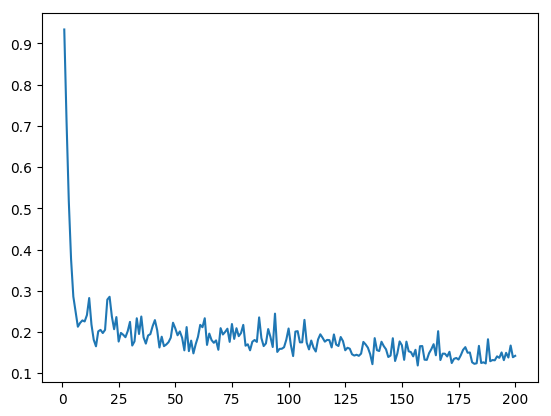

In [ ]:
# 读取图像绘图 
# 可以加一些修饰
loss=np.load('output_unet/unet.npy')
x=range(1,len(loss)+1)
plt.plot(x,loss)

In [ ]:
import os
def get_image_list(image_path):
    """Get image list"""
    valid_suffix = [
        '.JPEG', '.jpeg', '.JPG', '.jpg', '.BMP', '.bmp', '.PNG', '.png'
    ]
    image_list = []
    image_dir = None
    if os.path.isfile(image_path):
        if os.path.splitext(image_path)[-1] in valid_suffix:
            image_list.append(image_path)
    elif os.path.isdir(image_path):
        image_dir = image_path
        for root, dirs, files in os.walk(image_path):
            for f in files:
                if os.path.splitext(f)[-1] in valid_suffix:
                    image_list.append(os.path.join(root, f))
    else:
        raise FileNotFoundError(
            '`--image_path` is not found. it should be an image file or a directory including images'
        )

    if len(image_list) == 0:
        raise RuntimeError('There are not image file in `--image_path`')

    return image_list, image_dir
!pwd
image_path = 'dataset/test1_img/' # 也可以输入一个包含图像的目录
image_list, image_dir = get_image_list('dataset/test1_img/')

/home/aistudio/PaddleSeg


In [ ]:
!pwd
from paddleseg.utils import get_sys_env, logger, get_image_list
# image_path='dataset/test2_img/'
# image_list, image_dir = get_image_list(image_path)

import paddleseg.transforms as T
test_transforms = T.Compose([
    T.Resize(target_size=(256, 256)),
    T.Normalize()
])
from paddleseg.core import predict
predict(
        model=unet_model,
        model_path='output_unet/best_model/model.pdparams',
        transforms=test_transforms,
        image_list=image_list,
        image_dir='dataset/test1_img',
        save_dir='output_unet/results1'
    )

/home/aistudio/PaddleSeg
2023-12-21 23:31:11 [INFO]	Loading pretrained model from output_unet/best_model/model.pdparams
2023-12-21 23:31:12 [INFO]	There are 112/112 variables loaded into UNet.
2023-12-21 23:31:12 [INFO]	Start to predict...


262/262 [==============================] - 5s 18ms/ste


2023-12-21 23:31:16 [INFO]	Predicted images are saved in output_unet/results1/added_prediction and output_unet/results1/pseudo_color_prediction .


In [ ]:
def evaulate_miou(img_path,label_path):
    # print(imgs)
    iou=[]
    for img in os.listdir(img_path):
        imgpath=img_path+img
        img_1=cv2.imread(imgpath)
        img_test=np.zeros(img_1.shape[0:2])
        for n,i in enumerate(img_1):
            for m,j in enumerate(i):
                if j[1]==128:
                    img_test[n][m]=1
        data_path=label_path+img
        data=cv2.imread(data_path,-1)

        target=data
        prediction=img_test
        intersection = np.logical_and(target, prediction) 
        union = np.logical_or(target, prediction) 
        iou_score = np.sum(intersection) / np.sum(union)
        iou.append(iou_score)
    return iou

262
0.26233587300564903


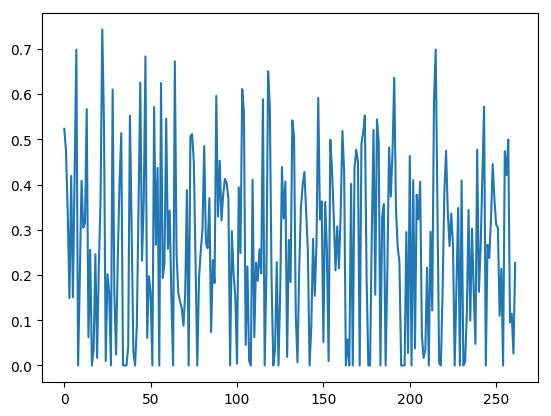

In [ ]:
img_path='/home/aistudio/PaddleSeg/output_unet/results1/pseudo_color_prediction/'
label_path='/home/aistudio/PaddleSeg/dataset/test1_label_img_in/'
iou_unet=evaulate_miou(img_path,label_path)
print(len(iou_unet))
print(sum(iou_unet)/len(iou_unet))
x=range(0,len(iou_unet))
y=iou_unet
plt.plot(x,y)
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7a2821f8d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7a28209290>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7a281fc7d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7a28209d10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7a28203790>],
 'means': []}

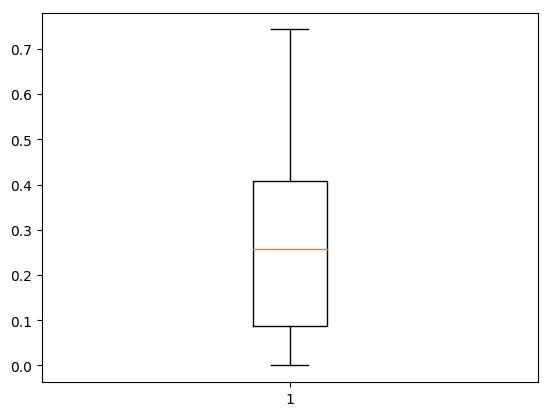

In [ ]:

# 绘制箱型图，观察离群值，说明大部分是正常预测的，除了极端部分，再解释下极端部分即可
fig, ax = plt.subplots()      # 子图
data=iou_unet
ax.boxplot(data)